## References

* HAT-P-44 b [(Fukui+16a)](http://iopscience.iop.org/article/10.3847/0004-637X/819/1/27/pdf)
* K2-3d [(Fukui+16b)](http://iopscience.iop.org/article/10.3847/0004-6256/152/6/171) 
* [HAT-P-44 b ref](http://exoplanet.eu/catalog/HAT-P-44_b/)
* [limb-darkening measurement](https://www.aanda.org/articles/aa/pdf/2013/12/aa22079-13.pdf)
* [stellar limb darkening and exoplanetary transits (Howarth 2011)](https://arxiv.org/pdf/1106.4659.pdf)

## To do

* See Narita et al. (2013) for modeling the ground-based transit light curves
* time stamps of the photometric data are placed onto the BJD$_{TDB}$ system using the code by Eastman et al. (2010)

In [1]:
!python --version

Python 2.7.13 :: Continuum Analytics, Inc.


In [2]:
import os
os.environ['CONDA_DEFAULT_ENV']

'astroconda'

## import and parse csv

In [3]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
cp = sb.color_palette()

%matplotlib inline
#import multiprocessing

In [4]:
import getpass
from glob import glob

data_dir = '/home/'+getpass.getuser()+'/data/transit/hatp44_data/lc_hatp44_msct_170215'
file_list=glob(data_dir+'/*.dat')
file_list.sort()

name='hatp44'
date='170215'
target_star_id='2'
comparison_star_id='1'#13, #3
radii_range='9-14'

data={}
bands='g,r,z'.split(',')
for b in bands:
    fname='lcf_msct_'+b+'_'+name+'_'+date+'_t'+target_star_id+'_c'+comparison_star_id+'_r'+radii_range+'.bjd.dat'
    df=pd.read_csv(os.path.join(data_dir,fname), delimiter=' ', parse_dates=True)
    df = df.set_index('BJD(TDB)-2450000')
    try:
        df=df.drop('Unnamed: 20',1)
    except:
        pass
    #df.head()
    data[b]=df

In [5]:
data.keys()

['r', 'z', 'g']

In [6]:
df.columns

Index([u'airmass', u'sky(ADU)', u'dx(pix)', u'dy(pix)', u'fwhm(pix)',
       u'peak(ADU)', u'frame', u'flux(r=9.0)', u'err(r=9.0)', u'flux(r=10.0)',
       u'err(r=10.0)', u'flux(r=11.0)', u'err(r=11.0)', u'flux(r=12.0)',
       u'err(r=12.0)', u'flux(r=13.0)', u'err(r=13.0)', u'flux(r=14.0)',
       u'err(r=14.0)'],
      dtype='object')

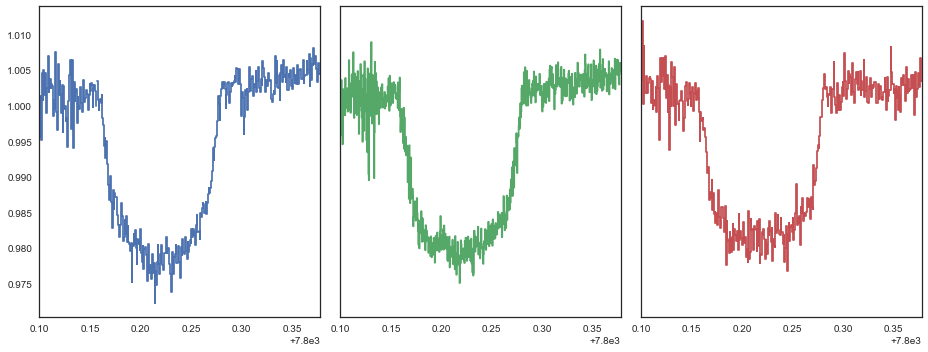

In [7]:
with sb.axes_style('white'):
    fig, axs = plt.subplots(1,3, figsize=(13,5), sharey=True)
    for i,b in enumerate(sorted(data.keys())):
        d=data[b]
        #remove irrelevant column
        d=d.drop('frame', axis=1)
        #dropna
        d=d.dropna(axis=0)
        #remove outliers
        d=d[np.abs(d-d.mean())<=(3*d.std())]
        
        f=d['flux(r=9.0)']
        t=f.index
        axs[i].plot(t,f, drawstyle='steps-mid', c=cp[i])
        plt.setp(axs, xlim=t[[0,-1]])
        fig.tight_layout()

## building the model

Based on Hartman et al. [2014](http://iopscience.iop.org/article/10.1088/0004-6256/147/6/128/pdf)
* Teff: 5295±100
* P: 4.301219±0.000019
* Tc: 2455696.93695±0.00024
* T14: 0.1302±0.0008
* Rp/R*: 0.1343±0.0010
* c1, i: 0.3648
* c2, i: 0.2817

Lightcurve parameters
* i: 88.7+0.6-1.6
* Mp: 0.347±0.077
* Rp: 1.523+0.442-0.226
* rho_p: 0.12
* log g: 2.55±0.19
* a: 0.0509+0.0014−0.0008
* Teq: 1238+173-107

In [8]:
def scaled_a(p, t14, k, inc=np.pi/2, b=0):
    numer = np.sqrt( (k + 1)**2 - b**2 )
    denom = np.sin(inc) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

### assumed true values

In [9]:
#k,tc,a,inc,u1,u2
k_   = 0.1343
tc_  = 2455696.93695
a_   = 0.0509
t14_ = 0.1302
p_   = 4.301219
i_   = 1.548107 #88.7 deg
u1_, u2_ = 0.4, 0.4

a_scaled_ = scaled_a(p_, t14_, k_, i_, b=0)
theta_true= [k_,tc_,a_scaled_, u1_, u2_]

### initial estimates

The only shared parameters among the 3 bands are:
* period, p
* inclination, i

In [10]:
ts = [data[k].index for k in sorted(data.keys())]
fluxes = [data[k]['flux(r=9.0)'] for k in sorted(data.keys())]

In [11]:
p   = 4.3
inc = np.pi/2.0
tc  = np.mean(ts[0])

k   = [np.sqrt(0.015)] * 3
t14 = [2.8/24] * 3
u1  = [0.4] * 3
u2  = [0.4] * 3

theta = []
a     = []

for n,j in enumerate(sorted(data.keys())):
    a.append(scaled_a(p, t14[n], k[n], inc=np.pi/2))
    theta.append([k[n],tc,a[n],inc,u1[n],u2[n]])
    print ("initial guess: {}".format(theta[n]))

initial guess: [0.1224744871391589, 7800.2386150452121, 13.18482235546915, 1.5707963267948966, 0.4, 0.4]
initial guess: [0.1224744871391589, 7800.2386150452121, 13.18482235546915, 1.5707963267948966, 0.4, 0.4]
initial guess: [0.1224744871391589, 7800.2386150452121, 13.18482235546915, 1.5707963267948966, 0.4, 0.4]


In [12]:
from pytransit import MandelAgol
MA = MandelAgol()

def model_u(theta, t, p):
    k,tc,a,i,u1,u2 = theta
    m = MA.evaluate(t, k, (u1, u2), tc, p, a, i)
    return m

import scipy.optimize as op

def obj(theta, t, p, f):
    m = model_u(theta, t, p)
    return np.sum((m-f)**2)

--g--
cost before: 0.0156410915558
cost after: 0.00434993313149
--r--
cost before: 0.0283927768659
cost after: 0.00726690360157
--z--
cost before: 0.0137784010213
cost after: 0.00373101713284


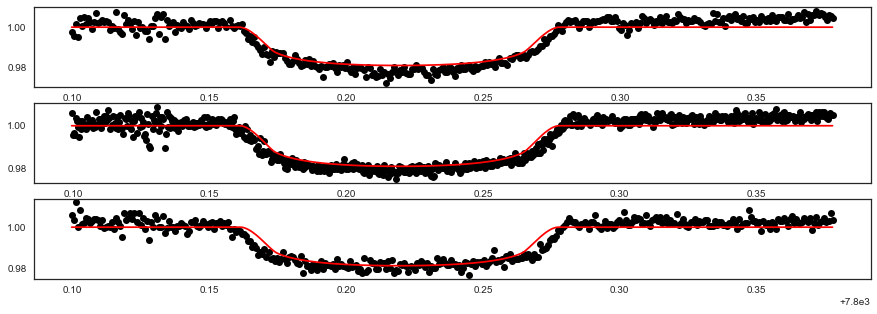

In [13]:
fig = plt.figure(figsize=(15,5))

with sb.axes_style('white'):
    for n,b in enumerate(sorted(bands)):
        d=data[b]
        #remove irrelevant column
        d=d.drop('frame', axis=1)
        #dropna
        d=d.dropna(axis=0)
        #remove outliers
        d=d[np.abs(d-d.mean())<=(3*d.std())]
        
        f=d['flux(r=9.0)']
        t=f.index
        print('--{}--'.format(b))
        print ("cost before: {}".format(obj(theta[n], t, p, f)))
        res = op.minimize(obj, theta[n], args=(t, p, f), method='nelder-mead')
        print ("cost after: {}".format(obj(res.x, t, p, f)))
        ax=plt.subplot(3,1,n+1)
        ax.plot(t, f, 'ko', t, model_u(res.x, t, p), 'r-');

## systematics model

In [14]:
#systematics model (time-dependent)
def model_s(theta, fwhm, uncertainty, xcenter, ycenter, t):
    #functional form of systematics model
    dummy = np.ones(len(fwhm))
    s = (np.array(theta)*np.c_[fwhm, xcenter, ycenter, dummy, t]).sum(axis=1)
    #s = [np.sum(c[k] * x**k) for k in np.arange(N)]
    # unpack 6 free params
    #a,b,c,d,e = theta
    #s = a + b*t + c*fwhm + d*xcenter + e*ycenter
    return s

def loglike(theta, t, f, p, fwhm, uncertainty, xcenter, ycenter, 
            ret_mod=False, ret_sys=False, ret_full = False):
    #g,r,z fluxes
    ls = theta[6]
    #k,tc,a,i,u1,u2
    m = model_u(theta[:6], t, p)
    s = model_s(theta[7:], fwhm, uncertainty, xcenter, ycenter, t) # #add sys model
    
    if ret_mod:
        return m
    if ret_sys:
        return s
    if ret_full:
        return m+s
    
    resid = f - m - s
    
    inv_sig2 = np.exp(-2*ls)
    
    return -0.5*(np.sum((resid)**2 * inv_sig2 + 2*ls))

#negative log-likelihood
nll = lambda *x: -loglike(*x)

--g--
NLL before: -1608.66726197
NLL after: -1989.49855384
--r--
NLL before: -2995.87635931
NLL after: -3393.55978457
--z--
NLL before: -1637.2482227
NLL after: -1769.4057829


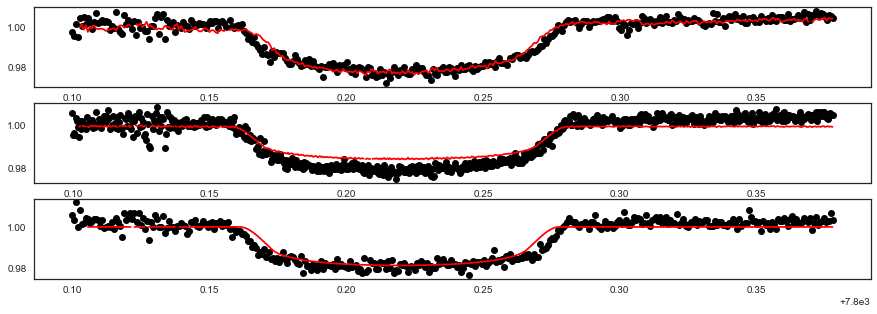

In [15]:
fig = plt.figure(figsize=(15,5))

#systematics parameters
k0, k1, k2, k3, k4 = [0]*5
    
with sb.axes_style('white'):
    for n,b in enumerate(sorted(bands)):
        d=data[b]
        #remove irrelevant column
        d=d.drop('frame', axis=1)
        #dropna
        d=d.dropna(axis=0)
        #remove outliers
        d=d[np.abs(d-d.mean())<=(3*d.std())]
        
        f=d['flux(r=9.0)']
        t=f.index
        
        #sys mod params
        uncertainty=d['err(r=9.0)'].values
        peak_flux=d['peak(ADU)'].values
        fwhm = d['fwhm(pix)'].values
        xcenter = d['dx(pix)'].values
        ycenter = d['dy(pix)'].values
        print('--{}--'.format(b))
        #log flux uncertainty
        ls = np.log(np.nanstd(f))
        #parameters vector: 6 free, 7 input
        theta = [k[n],tc,a[n],inc,u1[n],u2[n],ls,k0,k1,k2,k3,k4]
        print ("NLL before: {}".format(
            nll(theta, t, f, p, fwhm, uncertainty, xcenter, ycenter)))
        result = op.minimize(nll, theta, args=(
            t, f, p, fwhm, uncertainty, xcenter, ycenter), 
                             method='nelder-mead')
        print ("NLL after: {}".format(
            nll(result.x, t, f, p, fwhm, uncertainty, xcenter, ycenter)))
        f_pred = loglike(result.x, t, f, p, 
                         fwhm, uncertainty, xcenter, ycenter, ret_full=True)
        ax=plt.subplot(3,1,n+1)
        ax.plot(t, f, 'ko', t, f_pred, 'r-')

## MCMC

* Calculate Gelman-Rubin statistic for each parameter to ensure that the parameter chains have converged; Convergence is deemed adequate when the G-R statistic < 1.01
* track the average and median log likelihood at each step in the chain
* at t_b: ave log like < median log like indicates the transition from burn-in period to exploration of parameter space around the maximum likelihood solution
* remove the burn-in from our analysis

11 x 3 free + 3 shared = 36 parameters to optimize!

In [16]:
def logprior(theta,up=None):
    k,tc,a,i,u1,u2,ls,k0,k1,k2,k3,k4 =theta
    #priors on u, k, and inc
    if u1 < 0 or u1 > 2 or u2 < -1 or u2 > 1 or k < 0 or k > 1 or i > np.pi/2:
        return -np.inf
    
    lp = 0
    #u prior
    if up is not None:
        lp += np.log(stats.norm.pdf(u1, loc=up[0], scale=up[1]))
        lp += np.log(stats.norm.pdf(u2, loc=up[2], scale=up[3]))
    
    return lp

def logprob(theta,t1,t2,t3,f1,f2,f3,p,fwhm1,fwhm2,fwhm3, unc1,unc2,unc3,xcen1,xcen2,xcen3, ycen1,ycen2,ycen3,up=None):
    k1,k2,k3,tc,a1,a2,a3,i,u11,u12,u13,u21,u22,u23,ls1,ls2,ls3,k01,k02,k03,k11,k12,k13,k21,k22,k23,k31,k32,k33,k41,k42,k43 = theta
    theta1 = [k1,tc,a1,i,u11,u21,ls1,k01,k11,k21,k31,k41]
    theta2 = [k2,tc,a2,i,u12,u22,ls2,k02,k12,k22,k32,k42]
    theta3 = [k3,tc,a3,i,u13,u23,ls3,k03,k13,k23,k33,k43]
    
    #sum loglike for each band
    ll = loglike(theta1, t1, f1, p, fwhm1, unc1, xcen1, ycen1)
    ll += loglike(theta2, t2, f2, p, fwhm2, unc2, xcen2, ycen2)
    ll += loglike(theta3, t3, f3, p, fwhm3, unc3, xcen3, ycen3)
    
    if up is not None:
        lp = logprior(theta1,up=up[:4])
        lp += logprior(theta2,up=up[4:8])
        lp += logprior(theta3,up=up[8:12])
    else:
        lp = logprior(theta1)
        lp += logprior(theta2)
        lp += logprior(theta3)
    
    if np.isnan(ll).any():
        return -np.inf
    
    #total: sum of prior and likelihood
    return lp + ll

#negative log prob
nlp = lambda *x: -logprob(*x)

## sanity check: check logprob given init values

In [23]:
p   = 4.3
inc = np.pi/2.0
tc  = np.mean(ts[0])

k1,k2,k3     = [np.sqrt(0.015)] * 3   
u11,u12, u13 = [0.4] * 3
u21,u22, u23 = [0.4] * 3
a1,a2,a3     = a

#systematics parameters
k01, k11, k21, k31, k41 = [0] * 5
k02, k12, k22, k32, k42 = [0] * 5
k03, k13, k23, k33, k43 = [0] * 5
#log flux uncertainty
ls1,ls2,ls3 = [np.log(np.nanstd(f)) for f in fluxes]

theta = [k1,k2,k3,tc,a1,a2,a3,inc,u11,u12,u13,u21,u22,u23,ls1,ls2,ls3,k01,k02,k03,k11,k12,k13,k21,k22,k23,k31,k32,k33,k41,k42,k43]

uncs,peak_fluxes,fwhms,xcenters,ycenters=[],[],[],[],[]

for i,b in enumerate(sorted(bands)):
    d=data[b]
    #remove irrelevant column
    d=d.drop('frame', axis=1)
    #dropna
    d=d.dropna(axis=0)
    #remove outliers
    d=d[np.abs(d-d.mean())<=(3*d.std())]

    #sys mod params
    uncs.append(d['err(r=9.0)'].values)
    peak_fluxes.append(d['peak(ADU)'].values)
    fwhms.append(d['fwhm(pix)'].values)
    xcenters.append(d['dx(pix)'].values)
    ycenters.append(d['dy(pix)'].values)
    
t1,t2,t3         = ts
f1,f2,f3         = fluxes
fwhm1,fwhm2,fwhm3= fwhms
unc1,unc2,unc3   = uncs
xcen1,xcen2,xcen3= xcenters
ycen1,ycen2,ycen3= ycenters

args = [t1,t2,t3,f1,f2,f3,p,fwhm1,fwhm2,fwhm3, unc1,unc2,unc3,xcen1,xcen2,xcen3, ycen1,ycen2,ycen3]

uncs,peak_fluxes,fwhms,xcenters,ycenters=[],[],[],[],[]

for i,b in enumerate(sorted(bands)):
    d=data[b]
    #remove irrelevant column
    d=d.drop('frame', axis=1)
    #dropna
    d=d.dropna(axis=0)
    #remove outliers
    d=d[np.abs(d-d.mean())<=(3*d.std())]

    #sys mod params
    uncs.append(d['err(r=9.0)'].values)
    peak_fluxes.append(d['peak(ADU)'].values)
    fwhms.append(d['fwhm(pix)'].values)
    xcenters.append(d['dx(pix)'].values)
    ycenters.append(d['dy(pix)'].values)
    
t1,t2,t3         = ts
f1,f2,f3         = fluxes
fwhm1,fwhm2,fwhm3= fwhms
unc1,unc2,unc3   = uncs
xcen1,xcen2,xcen3= xcenters
ycen1,ycen2,ycen3= ycenters

args = [t1,t2,t3,f1,f2,f3,p,fwhm1,fwhm2,fwhm3, unc1,unc2,unc3,xcen1,xcen2,xcen3, ycen1,ycen2,ycen3]

logprob(theta, *args)

5719.1710490026308

In [24]:
from emcee import MHSampler, EnsembleSampler
from emcee.utils import sample_ball
from tqdm import tqdm

ndim = len(theta)
nwalkers = 8 * ndim if ndim > 12 else 16 * ndim
nsteps1 = 1000

sampler = EnsembleSampler(nwalkers, ndim, logprob, args=args, threads=1)

#random initial condition
pos0 = sample_ball(theta, [1e-4]*ndim, nwalkers)
# pos0 = [np.array(theta) + 1e-8 * np.random.randn(ndim)
#       for i in xrange(nwalkers)]

#begin
for pos,_,_ in tqdm(sampler.sample(pos0, iterations=nsteps1)):
    pass

0it [00:00, ?it/s]/home/jp/miniconda2/envs/astroconda/lib/python2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/jp/miniconda2/envs/astroconda/lib/python2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))
1000it [23:25,  1.55s/it]


## Initial results

In [26]:
param_names='k1,k2,k3,tc,a1,a2,a3,inc,u11,u12,u13,u21,u22,u23,ls1,ls2,ls3,k01,k02,k03,k11,k12,k13,k21,k22,k23,k31,k32,k33,k41,k42,k43'.split(',')

for n, i,j in zip(param_names, theta, sampler.flatchain.mean(axis=0)): 
    print('{0}:\tinit={1:.4f}\t, post={2:.4f}'.format(n,i,j))

k1:	init=0.1225	, post=0.1048
k2:	init=0.1225	, post=0.1313
k3:	init=0.1225	, post=0.1203
tc:	init=7800.2386	, post=7800.2248
a1:	init=13.1848	, post=13.3790
a2:	init=13.1848	, post=13.0535
a3:	init=13.1848	, post=13.5181
inc:	init=1.5708	, post=1.5658
u11:	init=0.4000	, post=0.4105
u12:	init=0.4000	, post=0.3236
u13:	init=0.4000	, post=0.3208
u21:	init=0.4000	, post=0.3854
u22:	init=0.4000	, post=0.3115
u23:	init=0.4000	, post=0.5661
ls1:	init=-2.9509	, post=-2.9791
ls2:	init=-4.5904	, post=-4.8183
ls3:	init=-4.6540	, post=-4.8388
k01:	init=0.0000	, post=0.0002
k02:	init=0.0000	, post=0.0001
k03:	init=0.0000	, post=0.0004
k11:	init=0.0000	, post=0.0025
k12:	init=0.0000	, post=-0.0004
k13:	init=0.0000	, post=0.0008
k21:	init=0.0000	, post=0.0032
k22:	init=0.0000	, post=-0.0002
k23:	init=0.0000	, post=-0.0011
k31:	init=0.0000	, post=0.0072
k32:	init=0.0000	, post=0.0611
k33:	init=0.0000	, post=0.0986
k41:	init=0.0000	, post=-0.0000
k42:	init=0.0000	, post=-0.0000
k43:	init=0.0000	, post

In [27]:
sampler.lnprobability

array([[             -inf,              -inf, -1428124.11088278, ...,
            6497.44432383,     6497.44432383,     6497.44432383],
       [ -317705.35820062,  -317705.35820062,  -146536.97704511, ...,
            6505.72217844,     6505.72217844,     6512.61993161],
       [ -676828.77386261,  -676828.77386261,  -429152.09119557, ...,
            6512.60123979,     6512.60123979,     6512.60123979],
       ..., 
       [-2151897.15192961, -2151897.15192961, -2151897.15192961, ...,
            6511.82445994,     6511.82445994,     6511.82445994],
       [-2928787.10667509, -2058449.83123833, -2058449.83123833, ...,
            6499.36641527,     6499.36641527,     6499.36641527],
       [             -inf,              -inf,              -inf, ...,
            6508.49737604,     6508.49737604,     6508.49737604]])

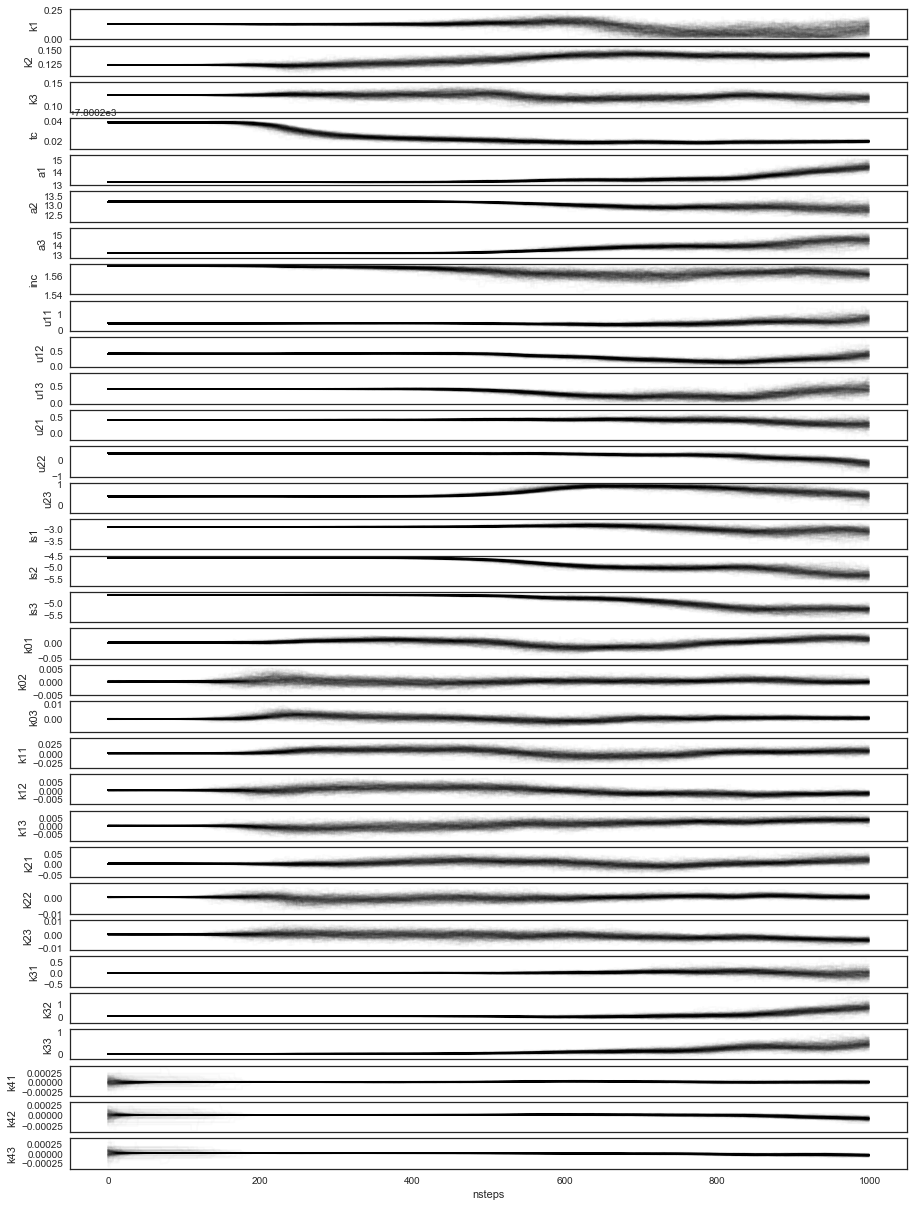

In [28]:
import seaborn as sb
import itertools

chain = sampler.chain

with sb.axes_style('white'):
    nwalkers, nsteps, ndim = chain.shape
    fig, axs = plt.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)
    #ls, lc = ['-','--','--'], ['k', '0.5', '0.5']
    #percs = [np.percentile(sampler.chain[:,:,i], [50,16,84], 0) for i in range(ndim)]
    [axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(chain.T)]
    #[[axs.flat[i].plot(percs[i][j], c=lc[j], ls=ls[j]) for j in range(3)] for i in range(ndim)]
    [axs.flat[i].set_ylabel(l) for i,l in enumerate(param_names)]
    
plt.xlabel('nsteps')

See [Knutson+2008]() how to determine the burn-in stage quantitatively.

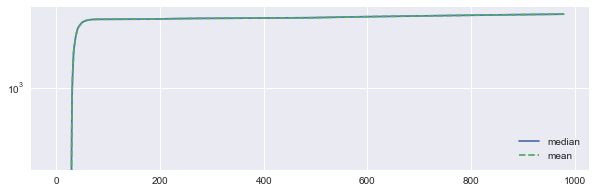

In [40]:
fig, ax = plt.subplots(1,1,figsize=(10,3))

med,mean=[],[]
ws = 20
for i in range(nsteps-ws):
    #nwalkers, nsteps, ndim
    med.append(np.median(sampler.lnprobability[:,i:(i+ws)])) #cumulative?
    mean.append(np.mean(sampler.lnprobability[:,i:(i+ws)]))
ax.plot(med,'-',label='median')
ax.plot(med,'--',label='mean')
#ax[j].set_title(param_names[j])
ax.legend()
ax.set_yscale('log')

In [44]:
dict(zip(param_names,pv))

{'a1': 14.904005800009807,
 'a2': 12.676402876685785,
 'a3': 14.614718887793867,
 'inc': 1.557704961001928,
 'k01': 0.0082980329673715356,
 'k02': -0.00071899974269763831,
 'k03': -0.00012534905872920929,
 'k1': 0.034353475727114086,
 'k11': 0.015101071721523654,
 'k12': -0.0016586892096352225,
 'k13': 0.0048537435752916379,
 'k2': 0.14346525482090611,
 'k21': 0.033870431539182233,
 'k22': -0.0005388230855629465,
 'k23': -0.0049905090400052306,
 'k3': 0.10205511474508713,
 'k31': 0.14102378941659013,
 'k32': 0.86024810140424446,
 'k33': 0.43031255623754683,
 'k41': -2.6227161432023421e-05,
 'k42': -0.00010933665096328494,
 'k43': -5.5349825829331807e-05,
 'ls1': -3.2127764136986583,
 'ls2': -5.5086349287168401,
 'ls3': -5.0475276124899207,
 'tc': 7800.2190424902992,
 'u11': 0.84383440274071353,
 'u12': 0.60483411410114851,
 'u13': 0.65931185837620243,
 'u21': 0.2829385789931177,
 'u22': -0.70886283644856274,
 'u23': 0.20970091218585435}

In [45]:
#sampler.flatchain.mean(axis=0)
max_idx=np.argmax(sampler.flatlnprobability)

#posterior of parameter vector
pv=sampler.flatchain[max_idx]
pv.tolist()

[0.034353475727114086,
 0.1434652548209061,
 0.10205511474508713,
 7800.219042490299,
 14.904005800009807,
 12.676402876685785,
 14.614718887793867,
 1.557704961001928,
 0.8438344027407135,
 0.6048341141011485,
 0.6593118583762024,
 0.2829385789931177,
 -0.7088628364485627,
 0.20970091218585435,
 -3.2127764136986583,
 -5.50863492871684,
 -5.047527612489921,
 0.008298032967371536,
 -0.0007189997426976383,
 -0.0001253490587292093,
 0.015101071721523654,
 -0.0016586892096352225,
 0.004853743575291638,
 0.03387043153918223,
 -0.0005388230855629465,
 -0.004990509040005231,
 0.14102378941659013,
 0.8602481014042445,
 0.43031255623754683,
 -2.622716143202342e-05,
 -0.00010933665096328494,
 -5.534982582933181e-05]

The chains did not converge. Run with longer nsteps. Use best estimates from the last chain as initial guesses in the new chain. Use also multiple threads.

In [80]:
sampler = EnsembleSampler(nwalkers, ndim, logprob, args=args, threads=1)

pos0_new = sample_ball(pv, [1e-4]*ndim, nwalkers)

for pos2,_,_ in tqdm(sampler.sample(pos0_new, iterations=nsteps1)):
    pass



0it [00:00, ?it/s]

1it [00:02,  2.87s/it]

2it [00:04,  2.43s/it]

3it [00:05,  2.12s/it]

4it [00:07,  1.91s/it]

5it [00:08,  1.77s/it]

6it [00:09,  1.67s/it]

7it [00:11,  1.64s/it]

8it [00:13,  1.60s/it]

9it [00:14,  1.56s/it]

10it [00:15,  1.52s/it]

11it [00:17,  1.52s/it]

12it [00:18,  1.47s/it]

13it [00:20,  1.51s/it]

14it [00:22,  1.57s/it]

15it [00:23,  1.55s/it]

16it [00:25,  1.52s/it]

17it [00:26,  1.55s/it]

18it [00:28,  1.50s/it]

19it [00:29,  1.48s/it]

20it [00:31,  1.56s/it]

21it [00:32,  1.40s/it]

22it [00:33,  1.47s/it]

23it [00:35,  1.58s/it]

24it [00:37,  1.63s/it]

25it [00:39,  1.63s/it]

26it [00:40,  1.62s/it]

27it [00:42,  1.80s/it]

28it [00:44,  1.83s/it]

29it [00:46,  1.81s/it]

30it [00:48,  1.75s/it]

31it [00:49,  1.71s/it]

32it [00:51,  1.68s/it]

33it [00:53,  1.68s/it]

34it [00:54,  1.66s/it]

35it [00:56,  1.63s/it]

36it [00:57,  1.56s/it]

37it [00:59,  1.57s/it]

38it [01:00,  1.56s/it]

39it [01:02,  1.54s/it]

40it [01:03,

259it [08:20,  1.68s/it]

260it [08:21,  1.58s/it]

261it [08:22,  1.49s/it]

262it [08:24,  1.46s/it]

263it [08:25,  1.47s/it]

264it [08:27,  1.48s/it]

265it [08:28,  1.47s/it]

266it [08:29,  1.43s/it]

267it [08:32,  1.86s/it]

268it [08:34,  1.96s/it]

269it [08:36,  1.78s/it]

270it [08:37,  1.66s/it]

271it [08:39,  1.57s/it]

272it [08:40,  1.52s/it]

273it [08:41,  1.51s/it]

274it [08:43,  1.51s/it]

275it [08:44,  1.49s/it]

276it [08:46,  1.55s/it]

277it [08:50,  2.15s/it]

278it [08:53,  2.44s/it]

279it [08:55,  2.28s/it]

280it [08:56,  2.00s/it]

281it [08:57,  1.82s/it]

282it [08:59,  1.71s/it]

283it [09:00,  1.66s/it]

284it [09:02,  1.60s/it]

285it [09:03,  1.53s/it]

286it [09:05,  1.51s/it]

287it [09:06,  1.47s/it]

288it [09:08,  1.46s/it]

289it [09:09,  1.48s/it]

290it [09:11,  1.67s/it]

291it [09:14,  2.01s/it]

292it [09:15,  1.83s/it]

293it [09:17,  1.70s/it]

294it [09:19,  1.72s/it]

295it [09:22,  2.12s/it]

296it [09:23,  1.92s/it]

297it [09:24

515it [16:27,  1.47s/it]

516it [16:30,  1.92s/it]

517it [16:31,  1.79s/it]

518it [16:33,  1.67s/it]

519it [16:34,  1.54s/it]

520it [16:37,  1.93s/it]

521it [16:39,  1.97s/it]

522it [16:40,  1.78s/it]

523it [16:42,  1.65s/it]

524it [16:44,  1.86s/it]

525it [16:47,  2.09s/it]

526it [16:48,  1.86s/it]

527it [16:49,  1.71s/it]

528it [16:51,  1.58s/it]

529it [16:52,  1.51s/it]

530it [16:53,  1.44s/it]

531it [16:55,  1.38s/it]

532it [16:56,  1.34s/it]

533it [16:57,  1.31s/it]

534it [16:58,  1.32s/it]

535it [17:00,  1.33s/it]

536it [17:01,  1.33s/it]

537it [17:02,  1.38s/it]

538it [17:06,  1.93s/it]

539it [17:07,  1.84s/it]

540it [17:09,  1.71s/it]

541it [17:10,  1.60s/it]

542it [17:13,  1.96s/it]

543it [17:15,  2.00s/it]

544it [17:16,  1.82s/it]

545it [17:18,  1.66s/it]

546it [17:19,  1.53s/it]

547it [17:20,  1.44s/it]

548it [17:22,  1.43s/it]

549it [17:23,  1.42s/it]

550it [17:24,  1.36s/it]

551it [17:25,  1.33s/it]

552it [17:27,  1.56s/it]

553it [17:31

771it [25:06,  2.31s/it]

772it [25:08,  2.28s/it]

773it [25:11,  2.50s/it]

774it [25:13,  2.18s/it]

775it [25:16,  2.46s/it]

776it [25:19,  2.80s/it]

777it [25:22,  2.81s/it]

778it [25:26,  3.17s/it]

779it [25:28,  2.77s/it]

780it [25:30,  2.38s/it]

781it [25:31,  2.07s/it]

782it [25:32,  1.85s/it]

783it [25:34,  1.71s/it]

784it [25:35,  1.63s/it]

785it [25:36,  1.55s/it]

786it [25:38,  1.55s/it]

787it [25:40,  1.71s/it]

788it [25:43,  2.22s/it]

789it [25:47,  2.52s/it]

790it [25:48,  2.31s/it]

791it [25:50,  2.00s/it]

792it [25:51,  1.90s/it]

793it [25:54,  2.01s/it]

794it [25:55,  1.85s/it]

795it [25:57,  1.72s/it]

796it [25:58,  1.66s/it]

797it [26:02,  2.28s/it]

798it [26:05,  2.67s/it]

799it [26:08,  2.74s/it]

800it [26:10,  2.44s/it]

801it [26:13,  2.57s/it]

802it [26:17,  2.97s/it]

803it [26:19,  2.87s/it]

804it [26:24,  3.31s/it]

805it [26:27,  3.14s/it]

806it [26:30,  3.26s/it]

807it [26:32,  2.95s/it]

808it [26:34,  2.48s/it]

809it [26:36

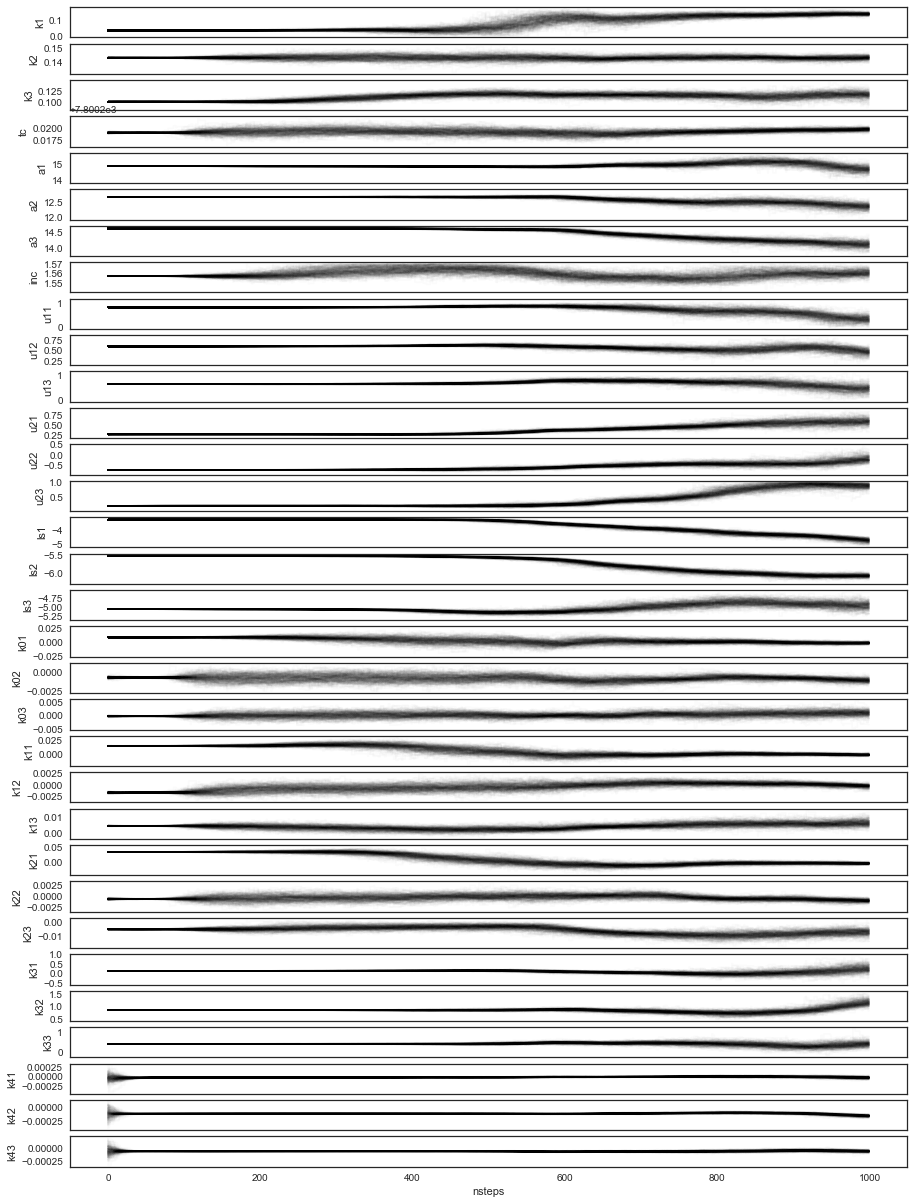

In [83]:
import seaborn as sb
import itertools

chain = sampler.chain

with sb.axes_style('white'):
    nwalkers, nsteps, ndim = chain.shape
    fig, axs = plt.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)
    #ls, lc = ['-','--','--'], ['k', '0.5', '0.5']
    #percs = [np.percentile(sampler.chain[:,:,i], [50,16,84], 0) for i in range(ndim)]
    [axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(chain.T)]
    #[[axs.flat[i].plot(percs[i][j], c=lc[j], ls=ls[j]) for j in range(3)] for i in range(ndim)]
    [axs.flat[i].set_ylabel(l) for i,l in enumerate(param_names)]
    
plt.xlabel('nsteps')

To decrease computational complexity, try to bin the data.

In [84]:
chain=sampler.chain
chain.shape

(256, 1000, 32)

In [99]:
#flat chain with burn-in removed, thinning applied
burn,thin=500,100
fc=chain[:,burn::thin,:].reshape([-1,chain.shape[-1]])
fc.shape #flattened

(1280, 32)

In [100]:
sampler.flatchain[burn::thin,:].shape

(2555, 32)

In [101]:
np.cov(np.c_[chain[:,1,:2]]).shape

(256, 256)

In [93]:
fc = chain[:,burn::thin,:].reshape([-1,chain.shape[-1]])

np.cov(np.c_[chain[:,1,:2]])

array([[  3.44787984e-02,   1.43574337e-01,   1.02212975e-01, ...,
         -1.02382282e-04,  -8.73930422e-05,  -7.72348323e-05],
       [  3.44787984e-02,   1.43574337e-01,   1.02212975e-01, ...,
         -1.02382282e-04,  -8.73930422e-05,  -7.72348323e-05],
       [  3.44787984e-02,   1.43574337e-01,   1.02212975e-01, ...,
         -1.02382282e-04,  -8.73930422e-05,  -7.72348323e-05],
       ..., 
       [  1.26950733e-01,   1.45007479e-01,   1.19317445e-01, ...,
         -5.56258140e-05,  -1.48657619e-04,  -3.31757947e-05],
       [  1.26950733e-01,   1.45007479e-01,   1.19317445e-01, ...,
         -5.56258140e-05,  -1.48657619e-04,  -3.31757947e-05],
       [  1.26950733e-01,   1.45007479e-01,   1.19317445e-01, ...,
         -5.56258140e-05,  -1.48657619e-04,  -3.31757947e-05]])

In [ ]:
burn = 500
#burn-in phase removed
#sampler.chain[:,burn:,:].shape

nsteps2 = 1000

sampler.reset()
for pos,_,_ in tqdm(sampler.sample(pos, iterations=nsteps2)):
    pass

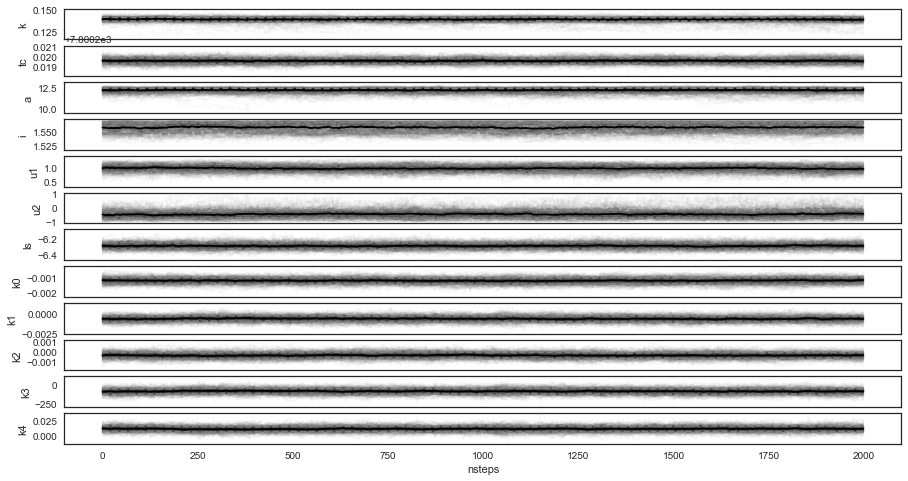

In [38]:
import seaborn as sb

chain = sampler.chain

with sb.axes_style('white'):
    nwalkers, nsteps, ndim = chain.shape
    fig, axs = plt.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)
    ls, lc = ['-','--','--'], ['k', '0.5', '0.5']
    percs = [np.percentile(sampler.chain[:,:,i], [50,16,84], 0) for i in range(ndim)]
    [axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(chain.T)]
    [[axs.flat[i].plot(percs[i][j], c=lc[j], ls=ls[j]) for j in range(3)] for i in range(ndim)]
    [axs.flat[i].set_ylabel(l) for i,l in enumerate(param_names)]
    
plt.xlabel('nsteps')

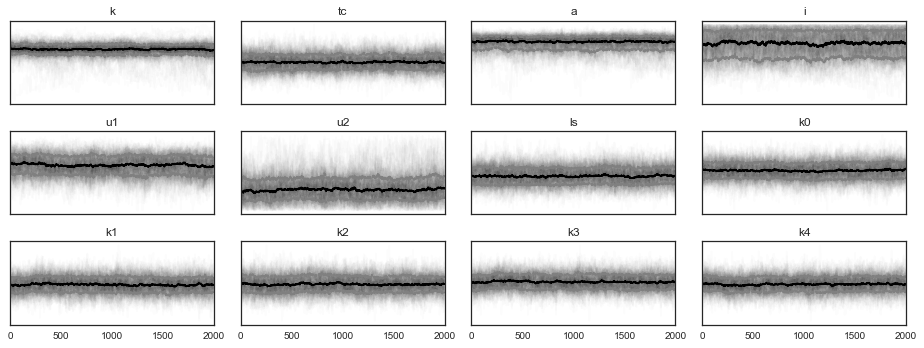

In [45]:
with sb.axes_style('white'):
    fig, axs = plt.subplots(3,4, figsize=(13,5), sharex=True)
    ls, lc = ['-','--','--'], ['k', '0.5', '0.5']
    percs = [np.percentile(sampler.chain[:,:,i], [50,16,84], 0) for i in range(len(theta))]
    [axs.flat[i].plot(sampler.chain[:,:,i].T, 'k', alpha=0.01) for i in range(len(theta))]
    [[axs.flat[i].plot(percs[i][j], c=lc[j], ls=ls[j]) for j in range(3)] for i in range(len(theta))]
    plt.setp(axs, yticks=[], xlim=[0,nsteps2])
    [axs.flat[i].set_title(l) for i,l in enumerate(param_names)]
    fig.tight_layout()

## Results

In [30]:
thin = 75
burn = 500

fc = sampler.chain[:,burn::thin,:].reshape([-1,sampler.chain.shape[-1]])
#mp = np.median(fc, axis=0)

## Parameter best estimates

In [31]:
pd.set_option('display.precision',4)
df = pd.DataFrame(data=fc.copy(), columns=param_names)
#df['k'] = np.sqrt(df.k2)
#df['u'] = 2*np.sqrt(df.q1)*df.q2
#df['v'] = np.sqrt(df.q1)*(1-2*df.q2)
#df = df.drop('k2', axis=1)
df.describe()

k1      k2      k3      tc      a1      a2      a3       i     u11  \
count  5120.0  5120.0  5120.0  5120.0  5120.0  5120.0  5120.0  5120.0  5120.0   
mean      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
std       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
min       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
25%       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
50%       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
75%       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
max       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

          u12   ...       k13     k21     k22     k23     k31     k32     k33  \
count  5120.0   ...    5120.0  5120.0  5120.0  5120.0  5120.0  5120.0  5120.0   
mean      0.0   ...       0.0     0.0     0.0     0.0     0.0     0.0     0.0   
std       0.0   ...       0.0     0.0     0.0     0.0     0.0     0.0     0.0   
min       0.0   ...       0.0     0.0     0.0     0.0     0.0     0.0     0.0   
25%       0.0   ...       0.0     0.0     0.0     0.0     0.0     0.0     0.0   
50%       0.0   ...       0.0     0.0     0.0     0.0     0.0     0.0     0.0   
75%       0.0   ...       0.0     0.0     0.0     0.0     0.0     0.0     0.0   
max       0.0   ...       0.0     0.0     0.0     0.0     0.0     0.0     0.0   

          k41     k42     k43  
count  5120.0  5120.0  5120.0  
mean      0.0     0.0     0.0  
std       0.0     0.0     0.0  
min       0.0     0.0     0.0  
25%       0.0     0.0     0.0  
50%       0.0     0.0     0.0  
75%       0.0     0.0     0.0  
max       0.0     0.0     0.0  

[8 rows x 32 columns]

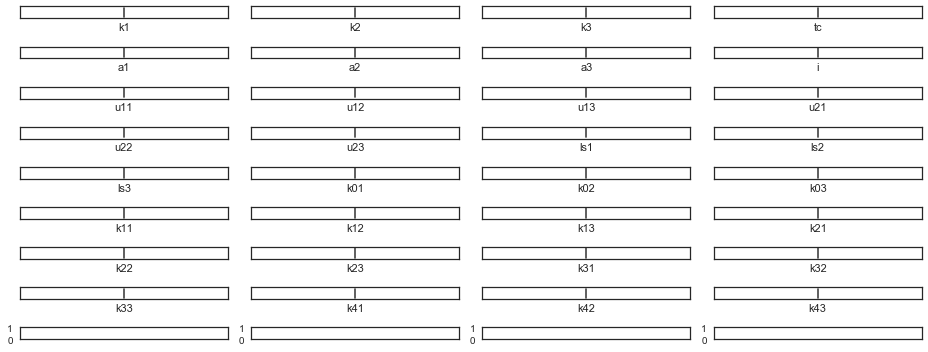

In [32]:
with sb.axes_style('white'):
    fig, axs = plt.subplots(9,4, figsize=(13,5))
    [sb.violinplot(df[p], ax=axs.flat[i]) for i,p in enumerate(param_names)]
    #[axs.flat[i].text(0.05,0.9, p, transform=axs.flat[i].transAxes) for i,p in enumerate(param_names)]
    plt.setp(axs, xticks=[], ylabel='')
    fig.tight_layout()

In [33]:
#using full chain excluding burn-in
max_idx=np.argmax(sampler.flatlnprobability)

#posterior of parameter vector
pv=sampler.flatchain[max_idx]
pv

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.])

In [34]:
#difference between the log prob max idx and chain median values
pv-mp

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.])

In [35]:
#posteriors: draw 100 random from fc
mod_sys = [loglike(pv, t, f, p, fwhm, unc1, xcen1, ycen1, ret_full=True) for th in fc[np.random.randint(0, fc.shape[0], size=100)]]
sys = [loglike(pv, t, f, p, fwhm, uncertainty, xcenter, ycenter, ret_sys=True) for th in fc[np.random.randint(0, fc.shape[0], size=100)]]
mod = [loglike(pv, t, f, p, fwhm, uncertainty, xcenter, ycenter, ret_mod=True) for th in fc[np.random.randint(0, fc.shape[0], size=100)]]

NameError: name 'fwhm' is not defined

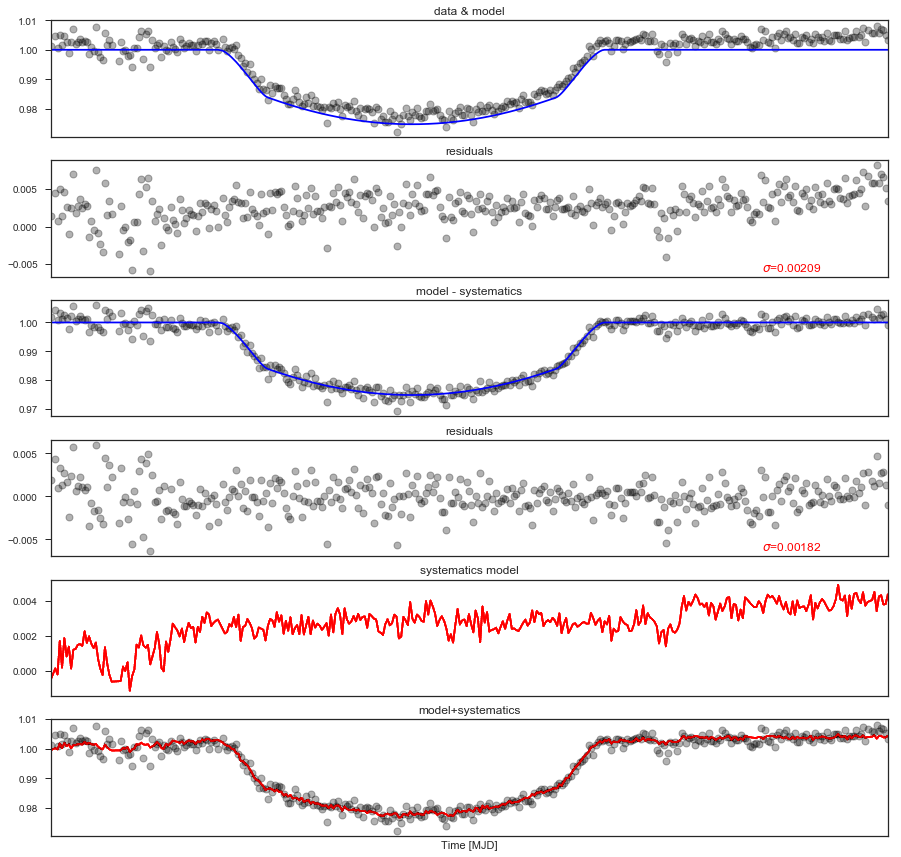

In [85]:
import seaborn as sb
n=0
#posterior
for th in fc[np.random.randint(0, fc.shape[0], size=100)]:
    ps = loglike(pv, t, f, p, fwhm, uncertainty, xcenter, ycenter, ret_full=True)


with sb.axes_style('ticks'):
    fig, ax = plt.subplots(6, 1, figsize=(15,15))
    ax[0].plot(t, f, linestyle='none', marker='o',
        color='k', alpha=0.3, mew=1, mec='k');
    ax[0].plot(t, mod[n], 'b-')
    ax[0].set_title('data & model')
    #residual
    ax[1].plot(t, f-mod[n], linestyle='none', marker='o',
        color='k', alpha=0.3, mew=1, mec='k');
    res1='$\sigma$={:.5f}'.format(np.std(f-mod[n]))
    ax[1].text(0.85,0.05,res1,transform=ax[1].transAxes,color='r')
    ax[1].set_title('residuals')
    #corrected
    ax[2].plot(t, f-sys[n], linestyle='none', marker='o',
        color='k', alpha=0.3, mew=1, mec='k');
    ax[2].plot(t, mod[n], 'b-')
    ax[2].set_title('model - systematics')
    #
    ax[3].plot(t, f-sys[n]-mod[0], linestyle='none', marker='o',
        color='k', alpha=0.3, mew=1, mec='k');
    #residual
    res2='$\sigma$={:.5f}'.format(np.std(f-sys[n]-mod[n]))
    ax[3].text(0.85,0.05,res2,transform=ax[3].transAxes,color='r')
    ax[3].set_title('residuals')
    for s in sys:
        ax[4].plot(t, s, 'r-', alpha=0.03)
        ax[4].set_title('systematics model')
    ax[5].plot(t, f, linestyle='none', marker='o',
        color='k', alpha=0.3, mew=1, mec='k');
    for s in ps:
        ax[5].plot(t, s, 'r-', alpha=0.03);
        ax[5].set_title('model+systematics')
plt.setp(ax, xticks=[], xlim=(t.min(), t.max()));
plt.xlabel('Time [MJD]')

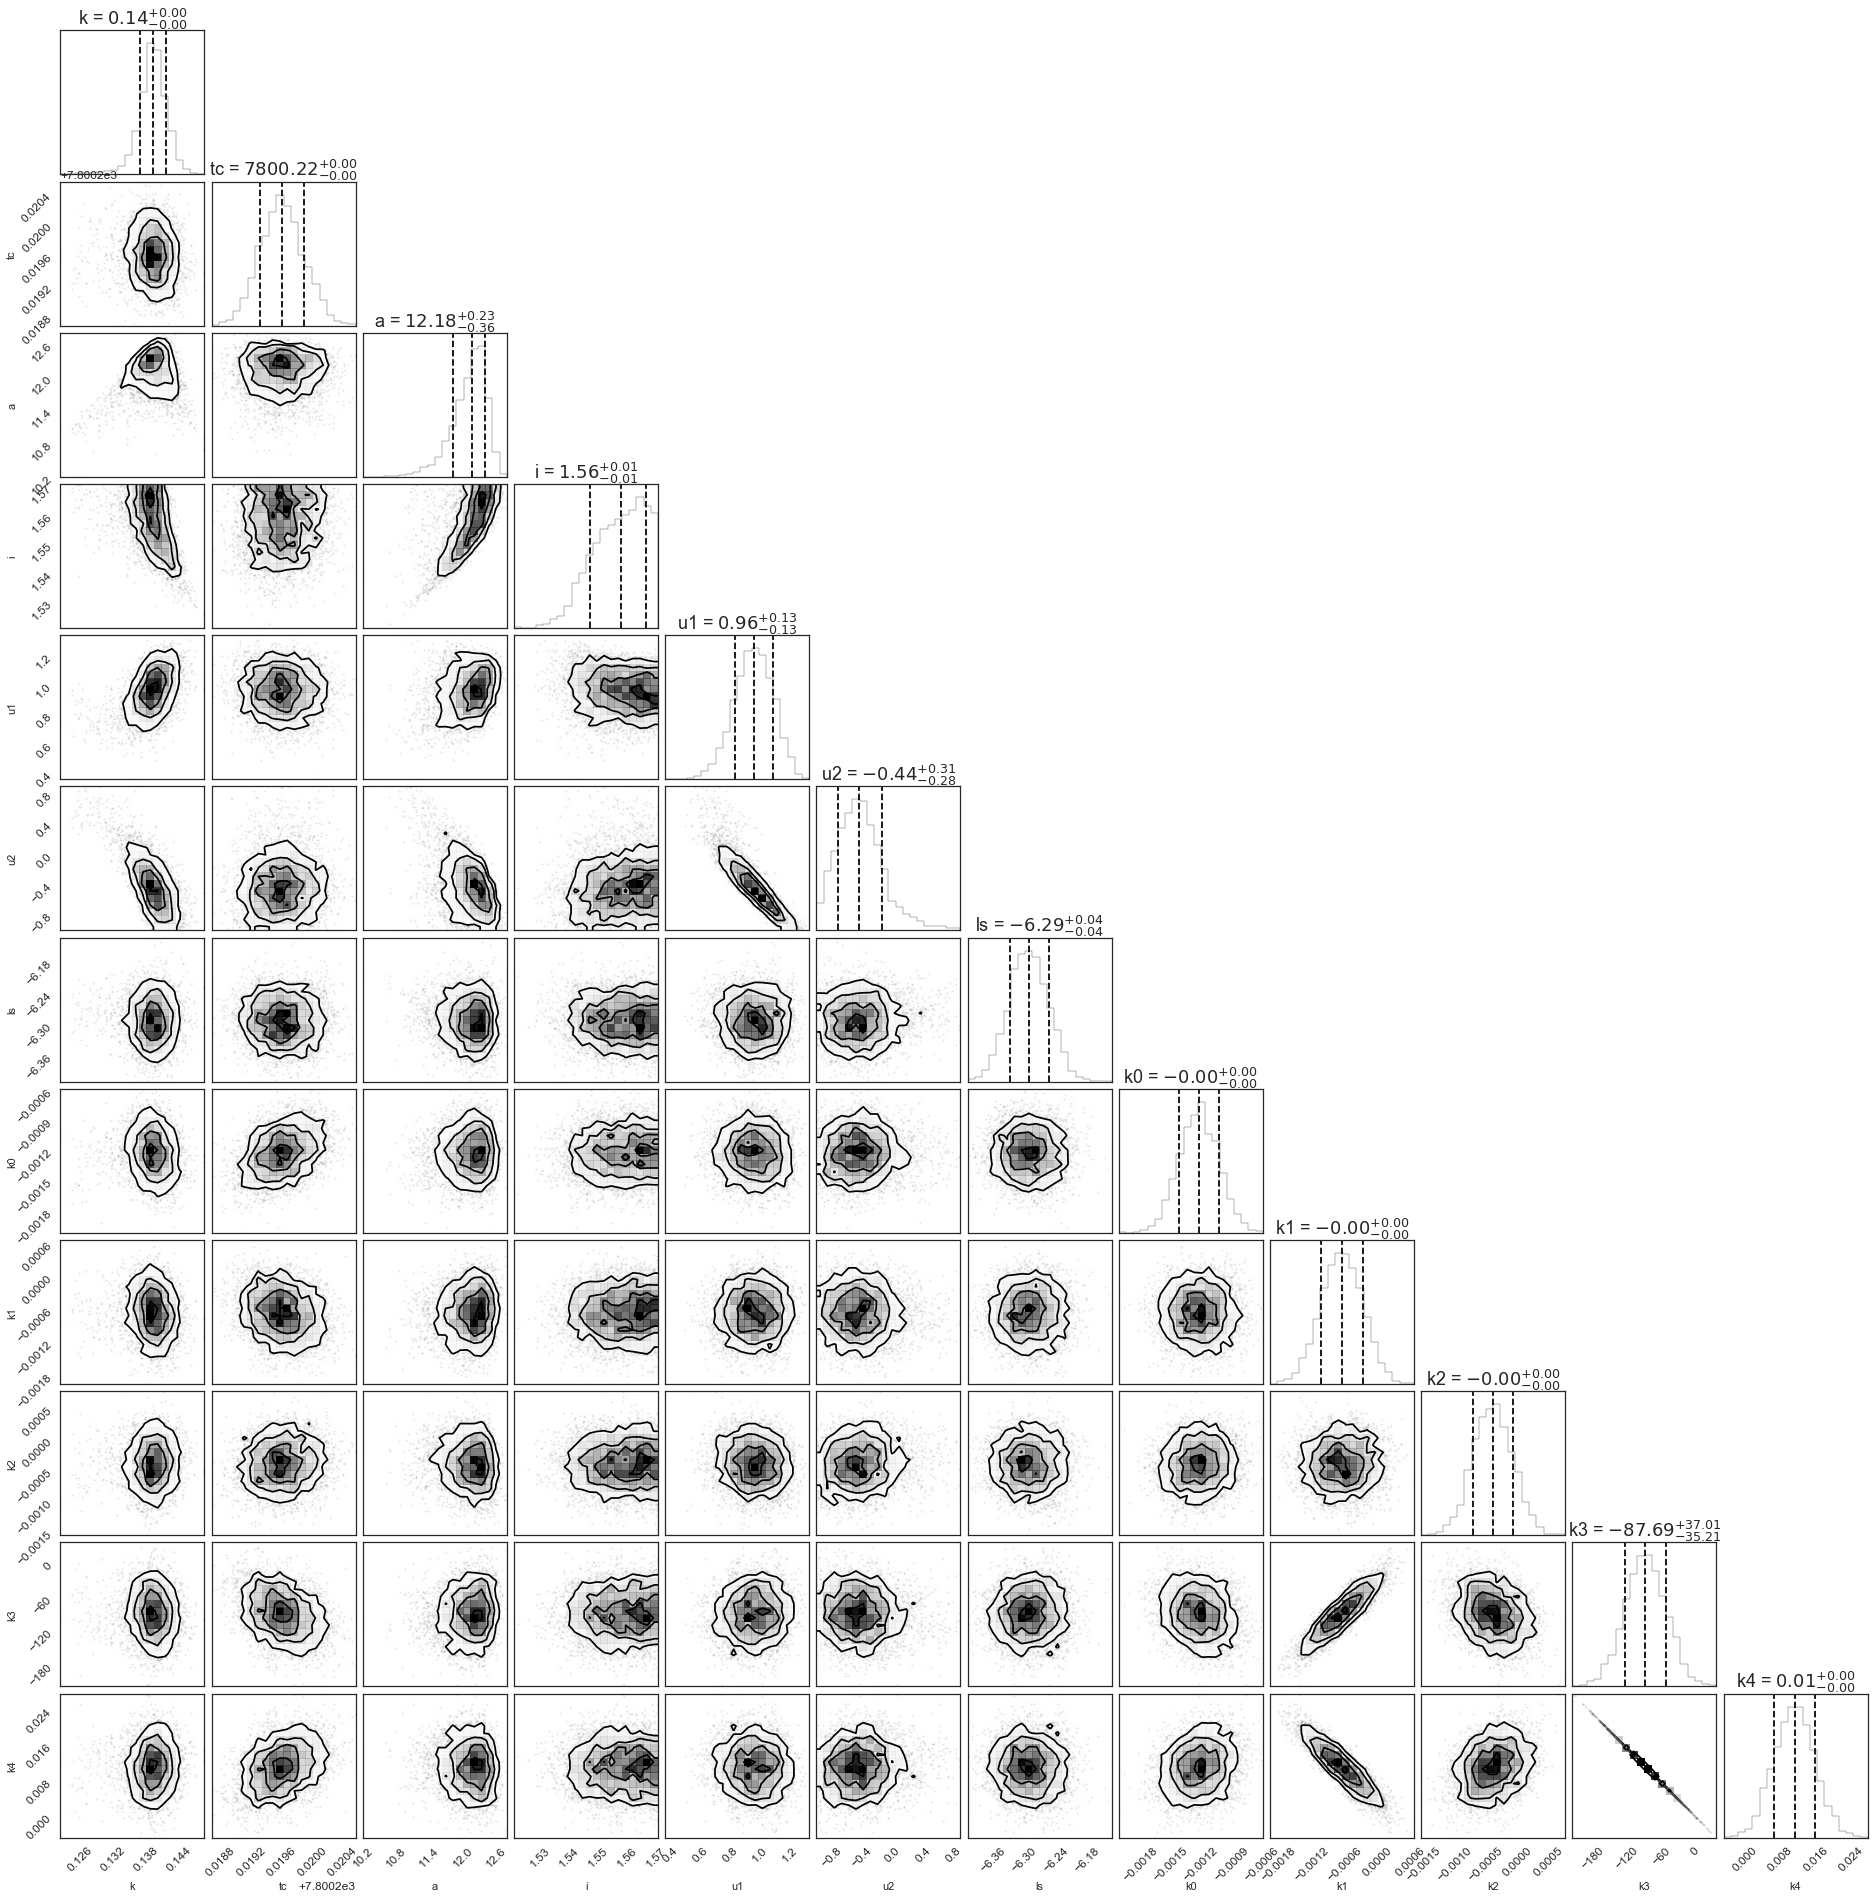

In [86]:
plt.rcParams['ytick.labelsize'] = 'medium'
plt.rcParams['xtick.labelsize'] = 'medium'

import corner

with sb.axes_style('white'):
    corner.corner(fc, labels=param_names, 
                  quantiles=[0.16, 0.5, 0.84], 
                  show_titles=True, title_kwargs={"fontsize": 18});

In [52]:
len(fc)

NameError: name 'fc' is not defined

correlation: u1, u2; k1, k3; i, a

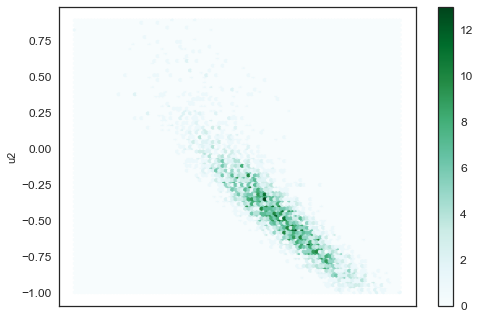

In [114]:
with sb.axes_style('white'):
    #fig, axs = plt.subplots(2,2, figsize=(13,5))
    cpars = dict(gridsize=15)
    df.plot(x='u1',y='u2',kind='hexbin')
    #plt.hexbin(df.u1,df.u2, **cpars)
    #plt.hexbin(df.k3,df.k1, **cpars)
    #plt.hexbin(df.k4,df.k1, **cpars)
    #plt.hexbin(df.i,df.a, **cpars)
    #setp(axs[0], xlabel='u', ylabel='v')
    #setp(axs[1], xlabel='b', ylabel='k')
    fig.tight_layout()

## Simultaneous

In [22]:
with sb.axes_style('white'):
    fig, axs = plt.subplots(1,3, figsize=(13,5), sharey=True)
    for i,b in enumerate(sorted(data.keys())):
        d=data[b]
        #remove irrelevant column
        d=d.drop('frame', axis=1)
        #dropna
        d=d.dropna(axis=0)
        #remove outliers
        d=d[np.abs(d-d.mean())<=(3*d.std())]
        
        f=d['flux(r=9.0)']
        t=f.index
            
        uncertainty=d['err(r=9.0)'].values#.dropna()
        peak_flux=d['peak(ADU)'].values#.dropna()
        fwhm = d['fwhm(pix)'].values#.dropna()
        xcenter = d['dx(pix)'].values#.dropna()
        ycenter = d['dy(pix)'].values#.dropna()
        
        args = t, f, p, fwhm, uncertainty, xcenter, ycenter
        sampler = EnsembleSampler(nwalkers, ndim, logprob,
            args=args, threads=1)

        #random initial condition
        pos0 = sample_ball(theta, [1e-4]*ndim, nwalkers)
        '''pos0 = [np.array(initial) + 1e-8 * np.random.randn(ndim)
              for i in xrange(nwalkers)]'''

        #begin
        for pos,_,_ in tqdm(sampler.sample(pos0, iterations=nsteps1)):
            pass
        chains.append(sampler.chain[:,burn::thin,:].reshape([-1,sampler.chain.shape[-1]]))
    chains = array(chains)

0it [00:00, ?it/s]/home/jp/miniconda2/envs/astroconda/lib/python2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/jp/miniconda2/envs/astroconda/lib/python2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))
1000it [01:07, 14.73it/s]


In [91]:
for n, i in zip(param_names, pv): 
    print('{0}: {1:.4f}'.format(n,i))

k: 0.1386
tc: 7800.2195
a: 12.3267
i: 1.5608
u1: 1.0031
u2: -0.5287
ls: -6.3125
k0: -0.0012
k1: -0.0006
k2: -0.0005
k3: -83.3635
k4: 0.0107


In [92]:
final_theta={}
final_theta['g']=pv

Compare the above results to previous [published results](http://exoplanet.eu/catalog/HAT-P-44_b/).

In [ ]:
with sb.axes_style('ticks'):
    fig, ax = plt.subplots(2, 1, figsize=(15,8))
    #data
    ax[0].plot(t, f, linestyle='none', marker='o',
        color='k', alpha=0.3, mew=1, mec='k')
    #model
    ax[0].plot(t, loglike(pv, t, f, p, fwhm, uncertainty, xcenter, ycenter, ret_mod=True), 
                   'b-', alpha=0.03)
    for s in ps: 
        #model+systematics
        ax[0].plot(t, s, 'r-', alpha=0.03)
    #residual
    res = loglike(pv, t, f, p, fwhm, uncertainty, xcenter, ycenter, ret_full=True)
    ax[1].plot(f-res, 'r-', label='residual')
    plt.setp(ax[0], xlabel='Time [BJD]',
        xlim=(t.min(), t.max()))
ax[0].legend(['data','model','data+sys'], loc='lower left')
ax[1].legend(loc='best')

In [ ]:
n=0
d1 = {'g_flux': f, 'g_mod': mod[n], 'g_sys':sys[n], 'g_full': mod_sys[n], 'g(f-sys)': f-sys[n]}
df1=pd.DataFrame(data=d1, index=t)
df1.head()

In [ ]:
f_MC_mod = loglike(pv, t, f, p, fwhm, uncertainty, xcenter, ycenter, ret_mod=True)
MC_sys = loglike(pv, t, f, p, fwhm, uncertainty, xcenter, ycenter, ret_sys=True)

In [ ]:
from pandas.tools.plotting import autocorrelation_plot

plt.figure()
autocorrelation_plot(MC_sys)

## r-band

In [ ]:
#target_star_id='2'
#comparison_star_id='1'#13, #3
#radii_range='9-14'

#fluxes
df=DF['g']
fluxes=df[df.columns[7:][::2]]
fluxes=fluxes[np.abs(fluxes-fluxes.mean())<=(3*fluxes.std())]
#add vertical offset
offset=0.05
for i,col in enumerate(fluxes.columns):
    fluxes[col].apply(lambda x : x-offset*i).plot(figsize=(15,10))

In [ ]:
idx=6 #flux(r=9.0)
key='r'
df_r=DF[key]
#move frame column
df_r=df_r.drop('frame', axis=1)
#remove outliers
df_r=df_r[np.abs(df_r-df_r.mean())<=(3*df_r.std())]
#dropna
df_r=df_r.dropna(axis=0)

#clip the right side of baseline
clip=40
#df_z=df_z[:-clip]

t=df_r.index.values
f=df_r[df_r.columns[idx]].values

fig = plt.figure(figsize=(15,5))
plt.plot(t, f, 'o', alpha=0.5)

In [ ]:
#df_r=DF[key]

#excluded outliers
uncertainty=df_r['err(r=9.0)'].values#.dropna()
peak_flux=df_r['peak(ADU)'].values#.dropna()
fwhm = df_r['fwhm(pix)'].values#.dropna()
xcenter = df_r['dx(pix)'].values#.dropna()
ycenter = df_r['dy(pix)'].values#.dropna()

In [ ]:
print ("NLL before: {}".format(nll(theta, t, f, p, fwhm, uncertainty, xcenter, ycenter)))
result = op.minimize(nll, theta, args=(t, f, p, fwhm, uncertainty, xcenter, ycenter), method='nelder-mead')
print ("NLL after: {}".format(nll(result.x, t, f, p, fwhm, uncertainty, xcenter, ycenter)))

In [ ]:
f_pred = loglike(result.x, t, f, p, fwhm, uncertainty, xcenter, ycenter, ret_full=True)
fig = plt.figure(figsize=(10,5))
plt.plot(t, f, 'ko', t, f_pred, 'r-')

In [ ]:
from emcee import MHSampler, EnsembleSampler
from emcee.utils import sample_ball
from tqdm import tqdm

ndim = len(theta)
nwalkers = 8 * ndim if ndim > 12 else 16 * ndim
nsteps1 = 1000

args = t, f, p, fwhm, uncertainty, xcenter, ycenter
sampler = EnsembleSampler(nwalkers, ndim, logprob,
    args=args, threads=1)

#random initial condition
pos0 = sample_ball(theta, [1e-4]*ndim, nwalkers)
'''pos0 = [np.array(initial) + 1e-8 * np.random.randn(ndim)
      for i in xrange(nwalkers)]'''

#begin
for pos,_,_ in tqdm(sampler.sample(pos0, iterations=nsteps1)):
    pass

In [ ]:
with sb.axes_style('white'):
    nwalkers, nsteps, ndim = chain.shape
    fig, axs = plt.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)
    [axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(chain.T)]
    [axs.flat[i].set_ylabel(l) for i,l in enumerate(param_names)]
    
plt.xlabel('nsteps')

In [ ]:
sampler.reset()
for pos,_,_ in tqdm(sampler.sample(pos, iterations=nsteps2)):
    pass

In [ ]:
chain = sampler.chain

with sb.axes_style('white'):
    nwalkers, nsteps, ndim = chain.shape
    fig, axs = plt.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)
    [axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(chain.T)]
    [axs.flat[i].set_ylabel(l) for i,l in enumerate(param_names)]
    
plt.xlabel('nsteps')

In [ ]:
#using full chain excluding burn-in
max_idx=np.argmax(sampler.flatlnprobability)

#posterior of parameter vector
pv=sampler.flatchain[max_idx]
pv

In [52]:
final_theta['r']=pv

In [53]:
#posteriors: draw 100 random from fc
mod_sys = [loglike(pv, t, f, p, fwhm, uncertainty, xcenter, ycenter, ret_full=True) for th in fc[np.random.randint(0, fc.shape[0], size=100)]]
sys = [loglike(pv, t, f, p, fwhm, uncertainty, xcenter, ycenter, ret_sys=True) for th in fc[np.random.randint(0, fc.shape[0], size=100)]]
mod = [loglike(pv, t, f, p, fwhm, uncertainty, xcenter, ycenter, ret_mod=True) for th in fc[np.random.randint(0, fc.shape[0], size=100)]]

In [54]:
n=0
d2 = {'r_flux': f, 'r_mod': mod[n], 'r_sys':sys[n], 'r_full': mod_sys[n], 'r(f-sys)': f-sys[n]}
df2=pd.DataFrame(data=d2, index=t)
df2.head()

r(f-sys)    r_flux    r_full  r_mod     r_sys
7800.102262  0.994856  0.994577  0.999721    1.0 -0.000279
7800.102655  1.002583  1.002315  0.999732    1.0 -0.000268
7800.103442  1.001979  1.002062  1.000083    1.0  0.000083
7800.103836  1.000690  1.001321  1.000631    1.0  0.000631
7800.104230  0.998527  0.999072  1.000545    1.0  0.000545

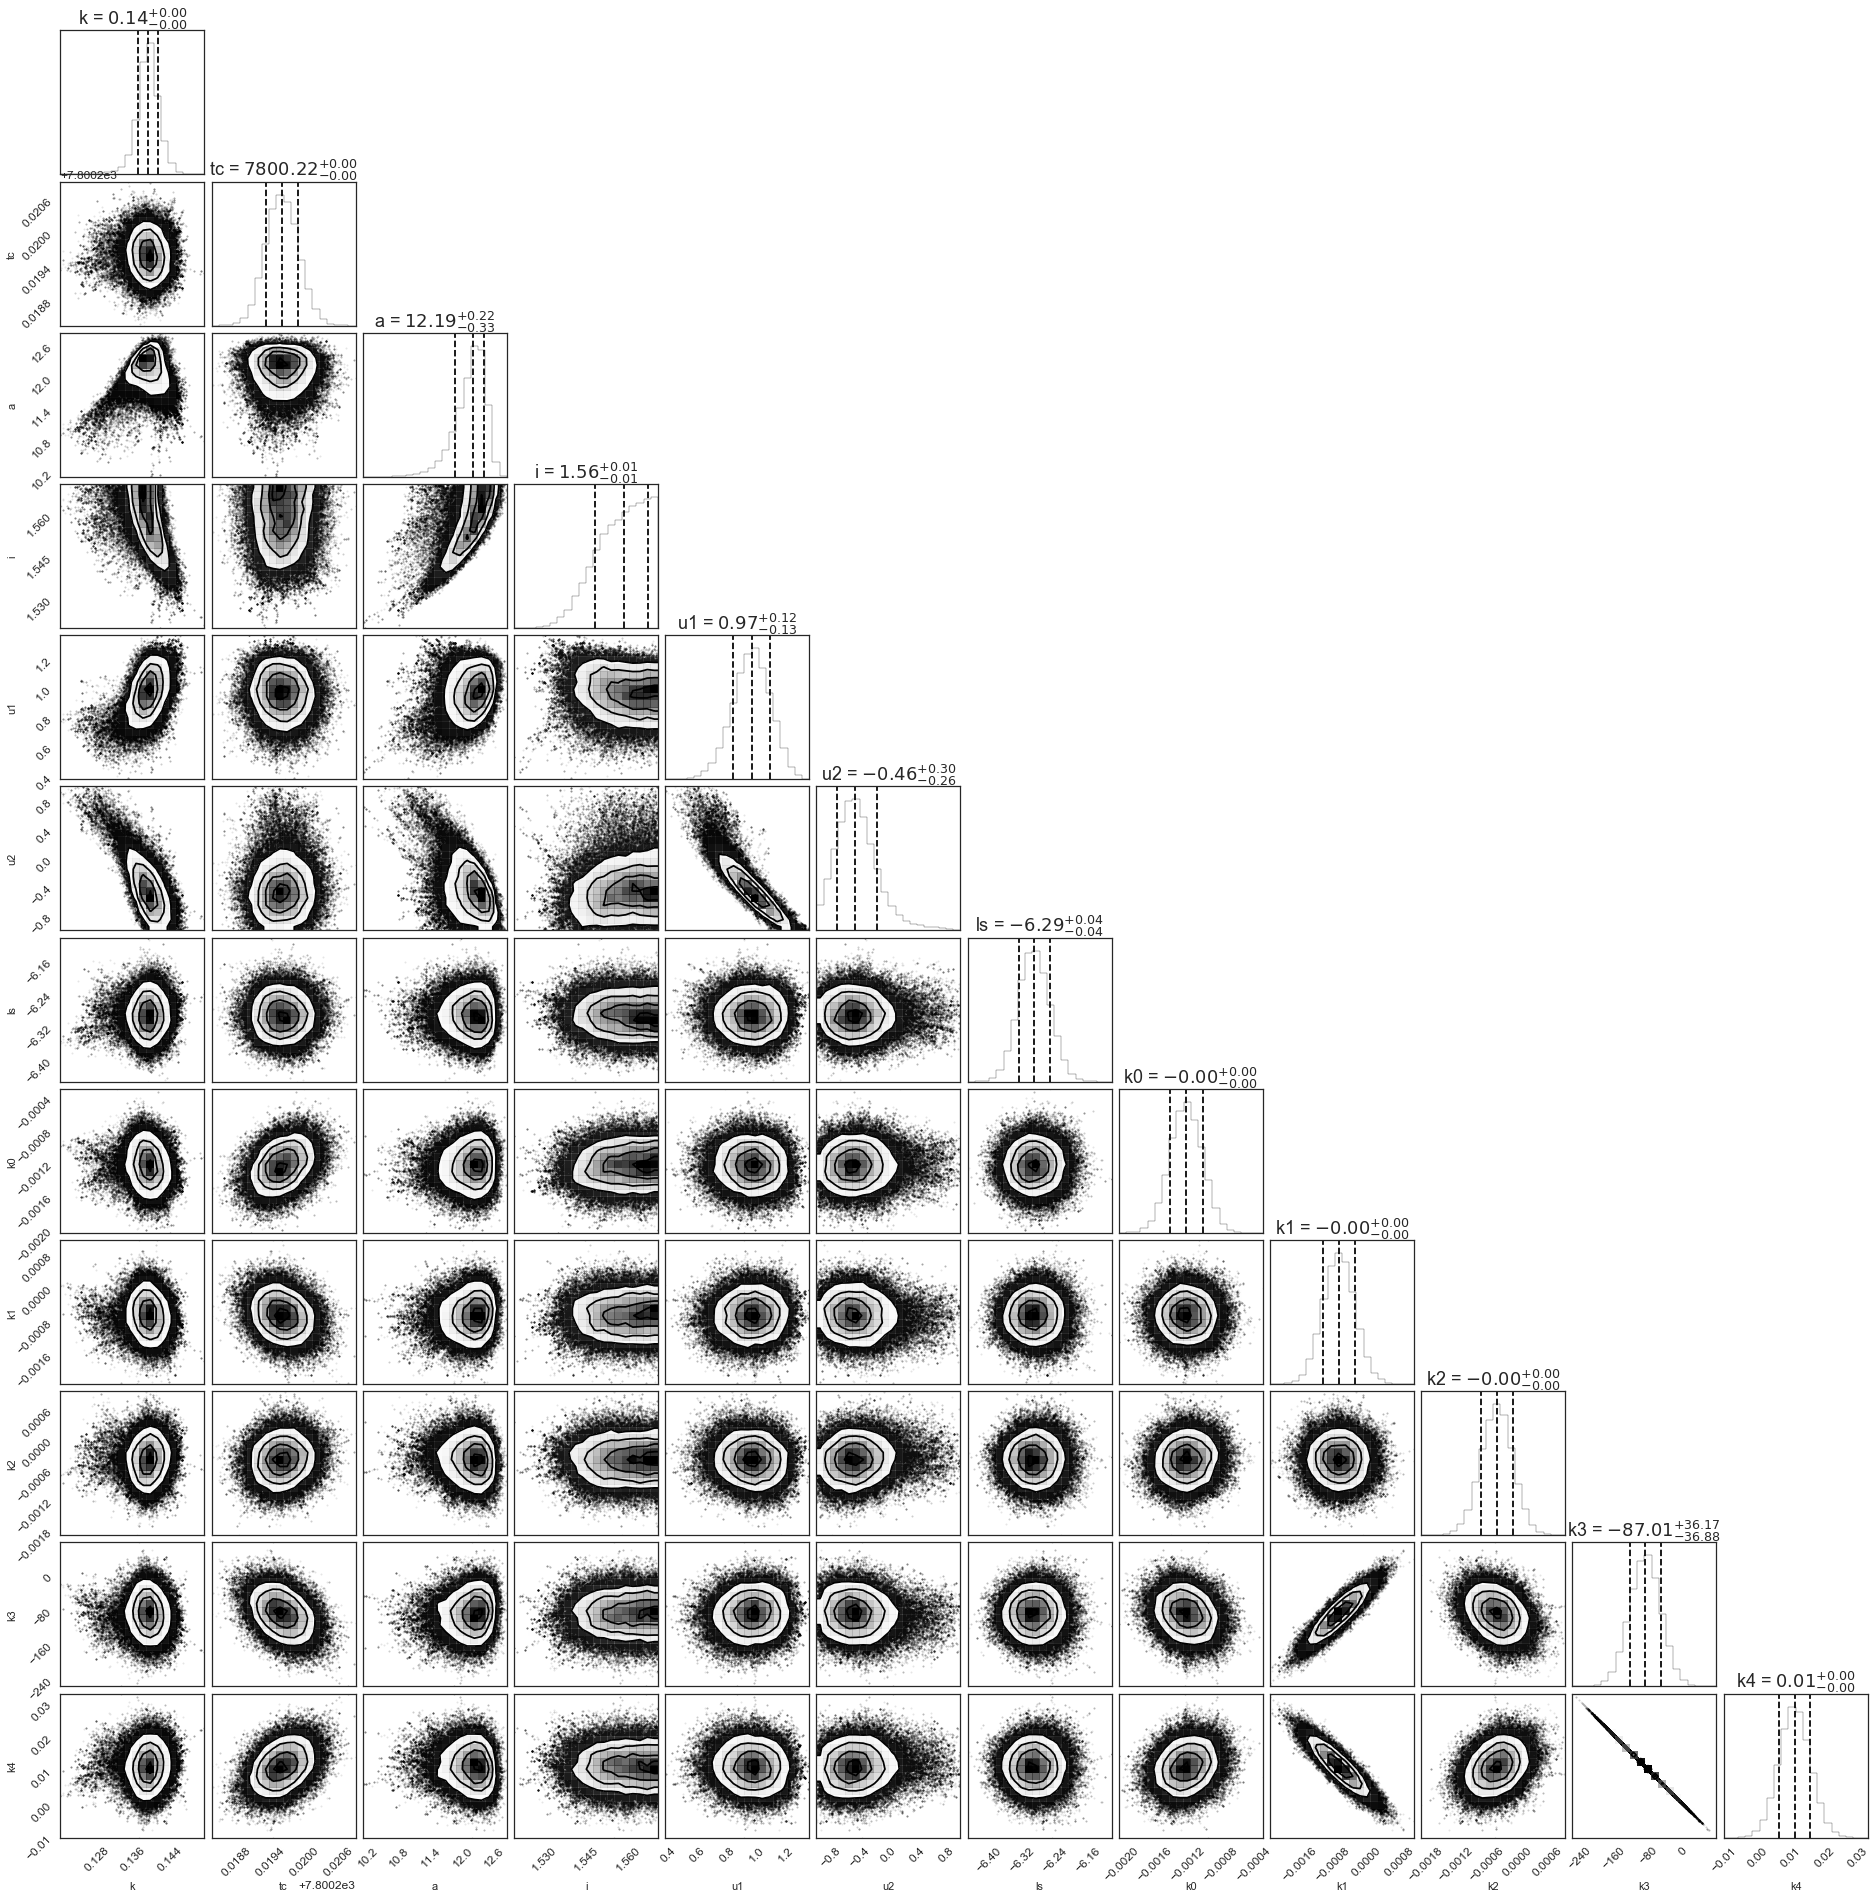

In [55]:
import corner

with sb.axes_style('white'):
    corner.corner(fc, labels=param_names, 
                  quantiles=[0.16, 0.5, 0.84], 
                  show_titles=True, title_kwargs={"fontsize": 18});

/home/jp/miniconda2/envs/moscatel/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  after removing the cwd from sys.path.


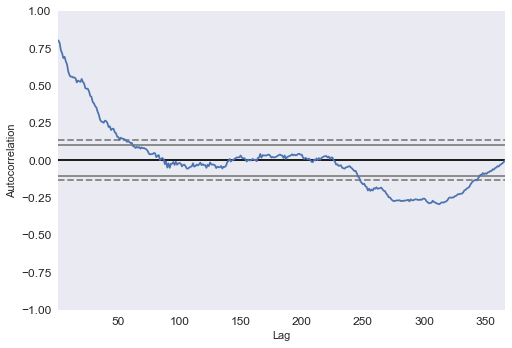

In [56]:
from pandas.tools.plotting import autocorrelation_plot

plt.figure()
autocorrelation_plot(MC_sys)

## z-band

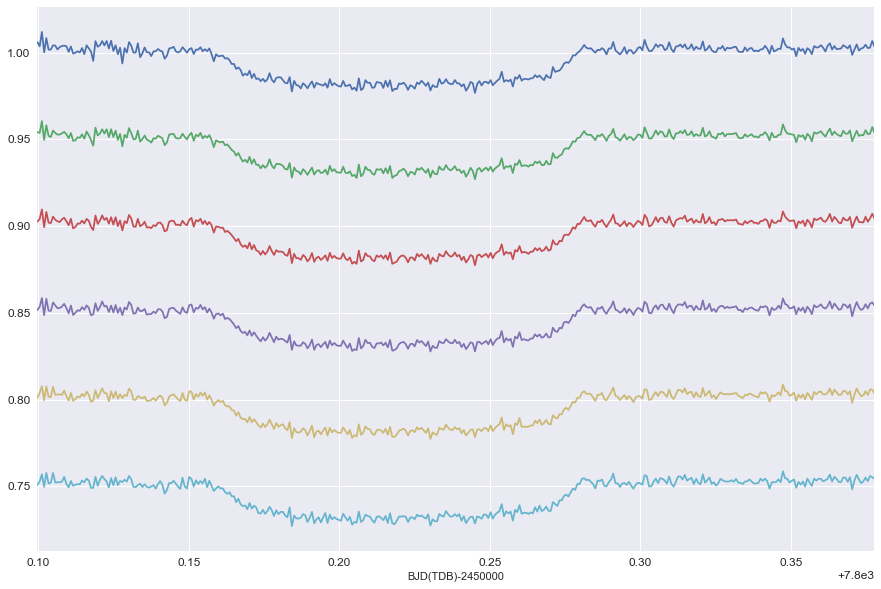

In [57]:
#target_star_id='2'
#comparison_star_id='1'#13, #3
#radii_range='9-14'

#fluxes
df=DF['z']
fluxes=df[df.columns[7:][::2]]
fluxes=fluxes[np.abs(fluxes-fluxes.mean())<=(3*fluxes.std())]
#add vertical offset
offset=0.05
for i,col in enumerate(fluxes.columns):
    fluxes[col].apply(lambda x : x-offset*i).plot(figsize=(15,10))

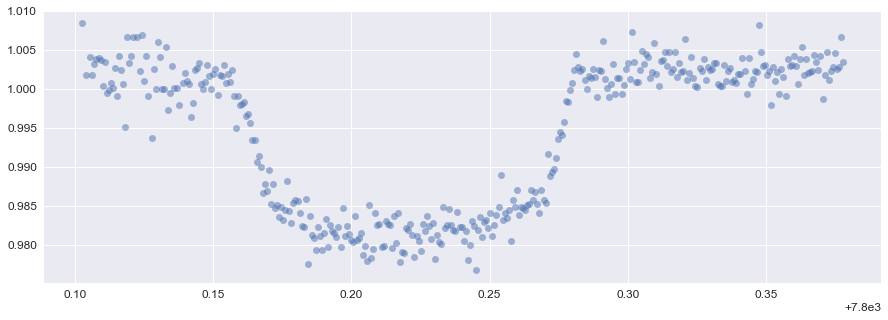

In [58]:
idx=6 #flux(r=9.0)
key='z'
df_z=DF[key]
#move frame column
df_z=df_z.drop('frame', axis=1)
#remove outliers
df_z=df_z[np.abs(df_z-df_z.mean())<=(3*df_z.std())]
#dropna
df_z=df_z.dropna(axis=0)

#clip the right side of baseline
clip=40
#df_z=df_z[:-clip]

t=df_z.index.values
f=df_z[df_z.columns[idx]].values

fig = plt.figure(figsize=(15,5))
plt.plot(t, f, 'o', alpha=0.5)

In [59]:
#df_r=DF[key]

#excluded outliers
uncertainty=df_z['err(r=9.0)'].values#.dropna()
peak_flux=df_z['peak(ADU)'].values#.dropna()
fwhm = df_z['fwhm(pix)'].values#.dropna()
xcenter = df_z['dx(pix)'].values#.dropna()
ycenter = df_z['dy(pix)'].values#.dropna()

In [60]:
print ("NLL before: {}".format(nll(theta, t, f, p, fwhm, uncertainty, xcenter, ycenter)))
result = op.minimize(nll, theta, args=(t, f, p, fwhm, uncertainty, xcenter, ycenter), method='nelder-mead')
print ("NLL after: {}".format(nll(result.x, t, f, p, fwhm, uncertainty, xcenter, ycenter)))

NLL before: -1605.38342975
NLL after: -2008.063847


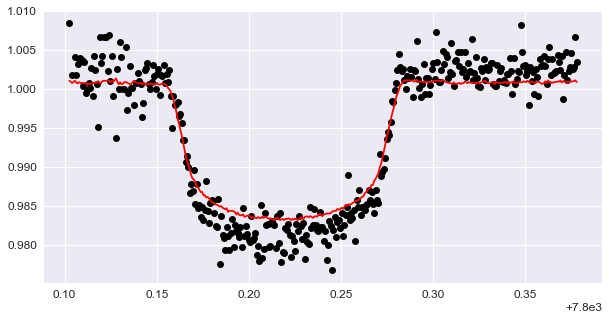

In [61]:
f_pred = loglike(result.x, t, f, p, fwhm, uncertainty, xcenter, ycenter, ret_full=True)
fig = plt.figure(figsize=(10,5))
plt.plot(t, f, 'ko', t, f_pred, 'r-')

In [62]:
from emcee import MHSampler, EnsembleSampler
from emcee.utils import sample_ball
from tqdm import tqdm

ndim = len(theta)
nwalkers = 8 * ndim if ndim > 12 else 16 * ndim
nsteps1 = 1000

args = t, f, p, fwhm, uncertainty, xcenter, ycenter
sampler = EnsembleSampler(nwalkers, ndim, logprob,
    args=args, threads=1)

#random initial condition
pos0 = sample_ball(theta, [1e-4]*ndim, nwalkers)
'''pos0 = [np.array(initial) + 1e-8 * np.random.randn(ndim)
      for i in xrange(nwalkers)]'''

#begin
for pos,_,_ in tqdm(sampler.sample(pos0, iterations=nsteps1)):
    pass

1000it [01:20, 12.45it/s]


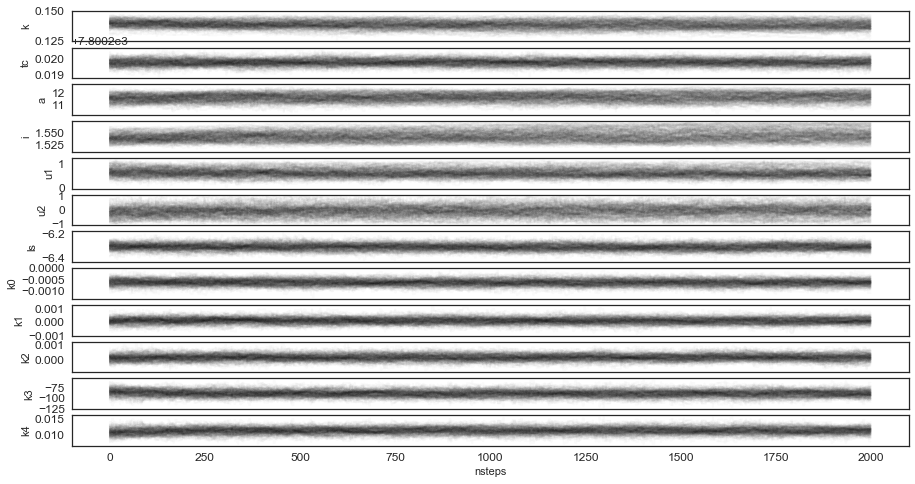

In [63]:
with sb.axes_style('white'):
    nwalkers, nsteps, ndim = chain.shape
    fig, axs = plt.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)
    [axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(chain.T)]
    [axs.flat[i].set_ylabel(l) for i,l in enumerate(param_names)]
    
plt.xlabel('nsteps')

In [64]:
sampler.reset()
for pos,_,_ in tqdm(sampler.sample(pos, iterations=nsteps2)):
    pass

2000it [02:33,  6.30it/s]


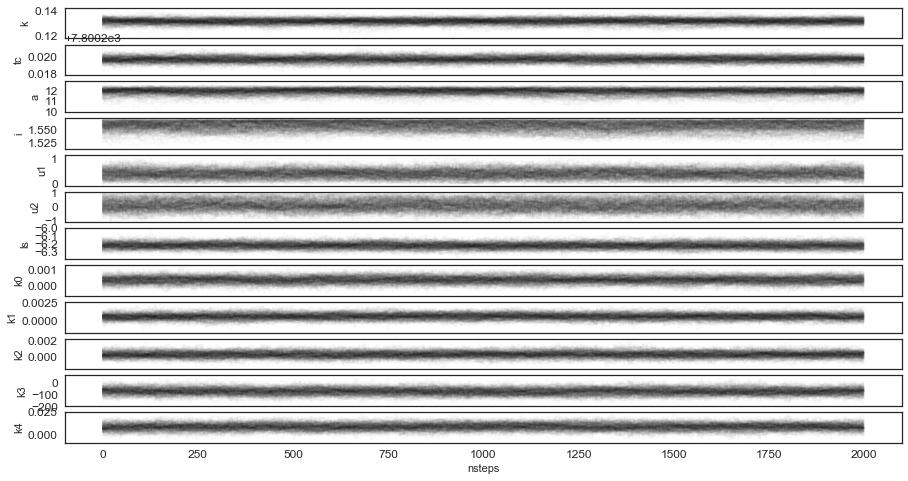

In [65]:
chain = sampler.chain

with sb.axes_style('white'):
    nwalkers, nsteps, ndim = chain.shape
    fig, axs = plt.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)
    [axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(chain.T)]
    [axs.flat[i].set_ylabel(l) for i,l in enumerate(param_names)]
    
plt.xlabel('nsteps')

In [66]:
#using full chain excluding burn-in
max_idx=np.argmax(sampler.flatlnprobability)

#posterior of parameter vector
pv=sampler.flatchain[max_idx]
pv

array([  1.31476947e-01,   7.80021952e+03,   1.21833227e+01,
         1.56703318e+00,   4.37250724e-01,   4.09970581e-02,
        -6.22634595e+00,   3.14129000e-04,   8.03857163e-04,
         2.74405717e-04,  -7.48213700e+01,   9.59212234e-03])

In [67]:
#
final_theta['z']=pv

In [68]:
#posteriors: draw 100 random from fc
mod_sys = [loglike(pv, t, f, p, fwhm, uncertainty, xcenter, ycenter, ret_full=True) for th in fc[np.random.randint(0, fc.shape[0], size=100)]]
sys = [loglike(pv, t, f, p, fwhm, uncertainty, xcenter, ycenter, ret_sys=True) for th in fc[np.random.randint(0, fc.shape[0], size=100)]]
mod = [loglike(pv, t, f, p, fwhm, uncertainty, xcenter, ycenter, ret_mod=True) for th in fc[np.random.randint(0, fc.shape[0], size=100)]]

In [69]:
n=0
d3 = {'z_flux': f, 'z_mod': mod[n], 'z_sys':sys[n], 'z_full': mod_sys[n], 'z(f-sys)': f-sys[n]}
df3=pd.DataFrame(data=d3, index=t)
df3.head()

z(f-sys)    z_flux    z_full  z_mod     z_sys
7800.102655  1.006425  1.008416  1.001991    1.0  0.001991
7800.104149  1.000005  1.001797  1.001792    1.0  0.001792
7800.105631  1.002652  1.004066  1.001414    1.0  0.001414
7800.106360  0.999495  1.001821  1.002326    1.0  0.002326
7800.107101  1.001236  1.003172  1.001936    1.0  0.001936

In [70]:
frames = [df1, df2, df3]

final_df = pd.concat(frames)
final_df.tail()

g(f-sys)  g_flux  g_full  g_mod  g_sys  r(f-sys)  r_flux  r_full  \
7800.374841       NaN     NaN     NaN    NaN    NaN       NaN     NaN     NaN   
7800.375582       NaN     NaN     NaN    NaN    NaN       NaN     NaN     NaN   
7800.376323       NaN     NaN     NaN    NaN    NaN       NaN     NaN     NaN   
7800.377063       NaN     NaN     NaN    NaN    NaN       NaN     NaN     NaN   
7800.377793       NaN     NaN     NaN    NaN    NaN       NaN     NaN     NaN   

             r_mod  r_sys  z(f-sys)    z_flux    z_full  z_mod     z_sys  
7800.374841    NaN    NaN  1.002120  1.004588  1.002468    1.0  0.002468  
7800.375582    NaN    NaN  1.000176  1.002619  1.002443    1.0  0.002443  
7800.376323    NaN    NaN  1.000234  1.002866  1.002632    1.0  0.002632  
7800.377063    NaN    NaN  1.004055  1.006726  1.002671    1.0  0.002671  
7800.377793    NaN    NaN  1.001027  1.003414  1.002387    1.0  0.002387

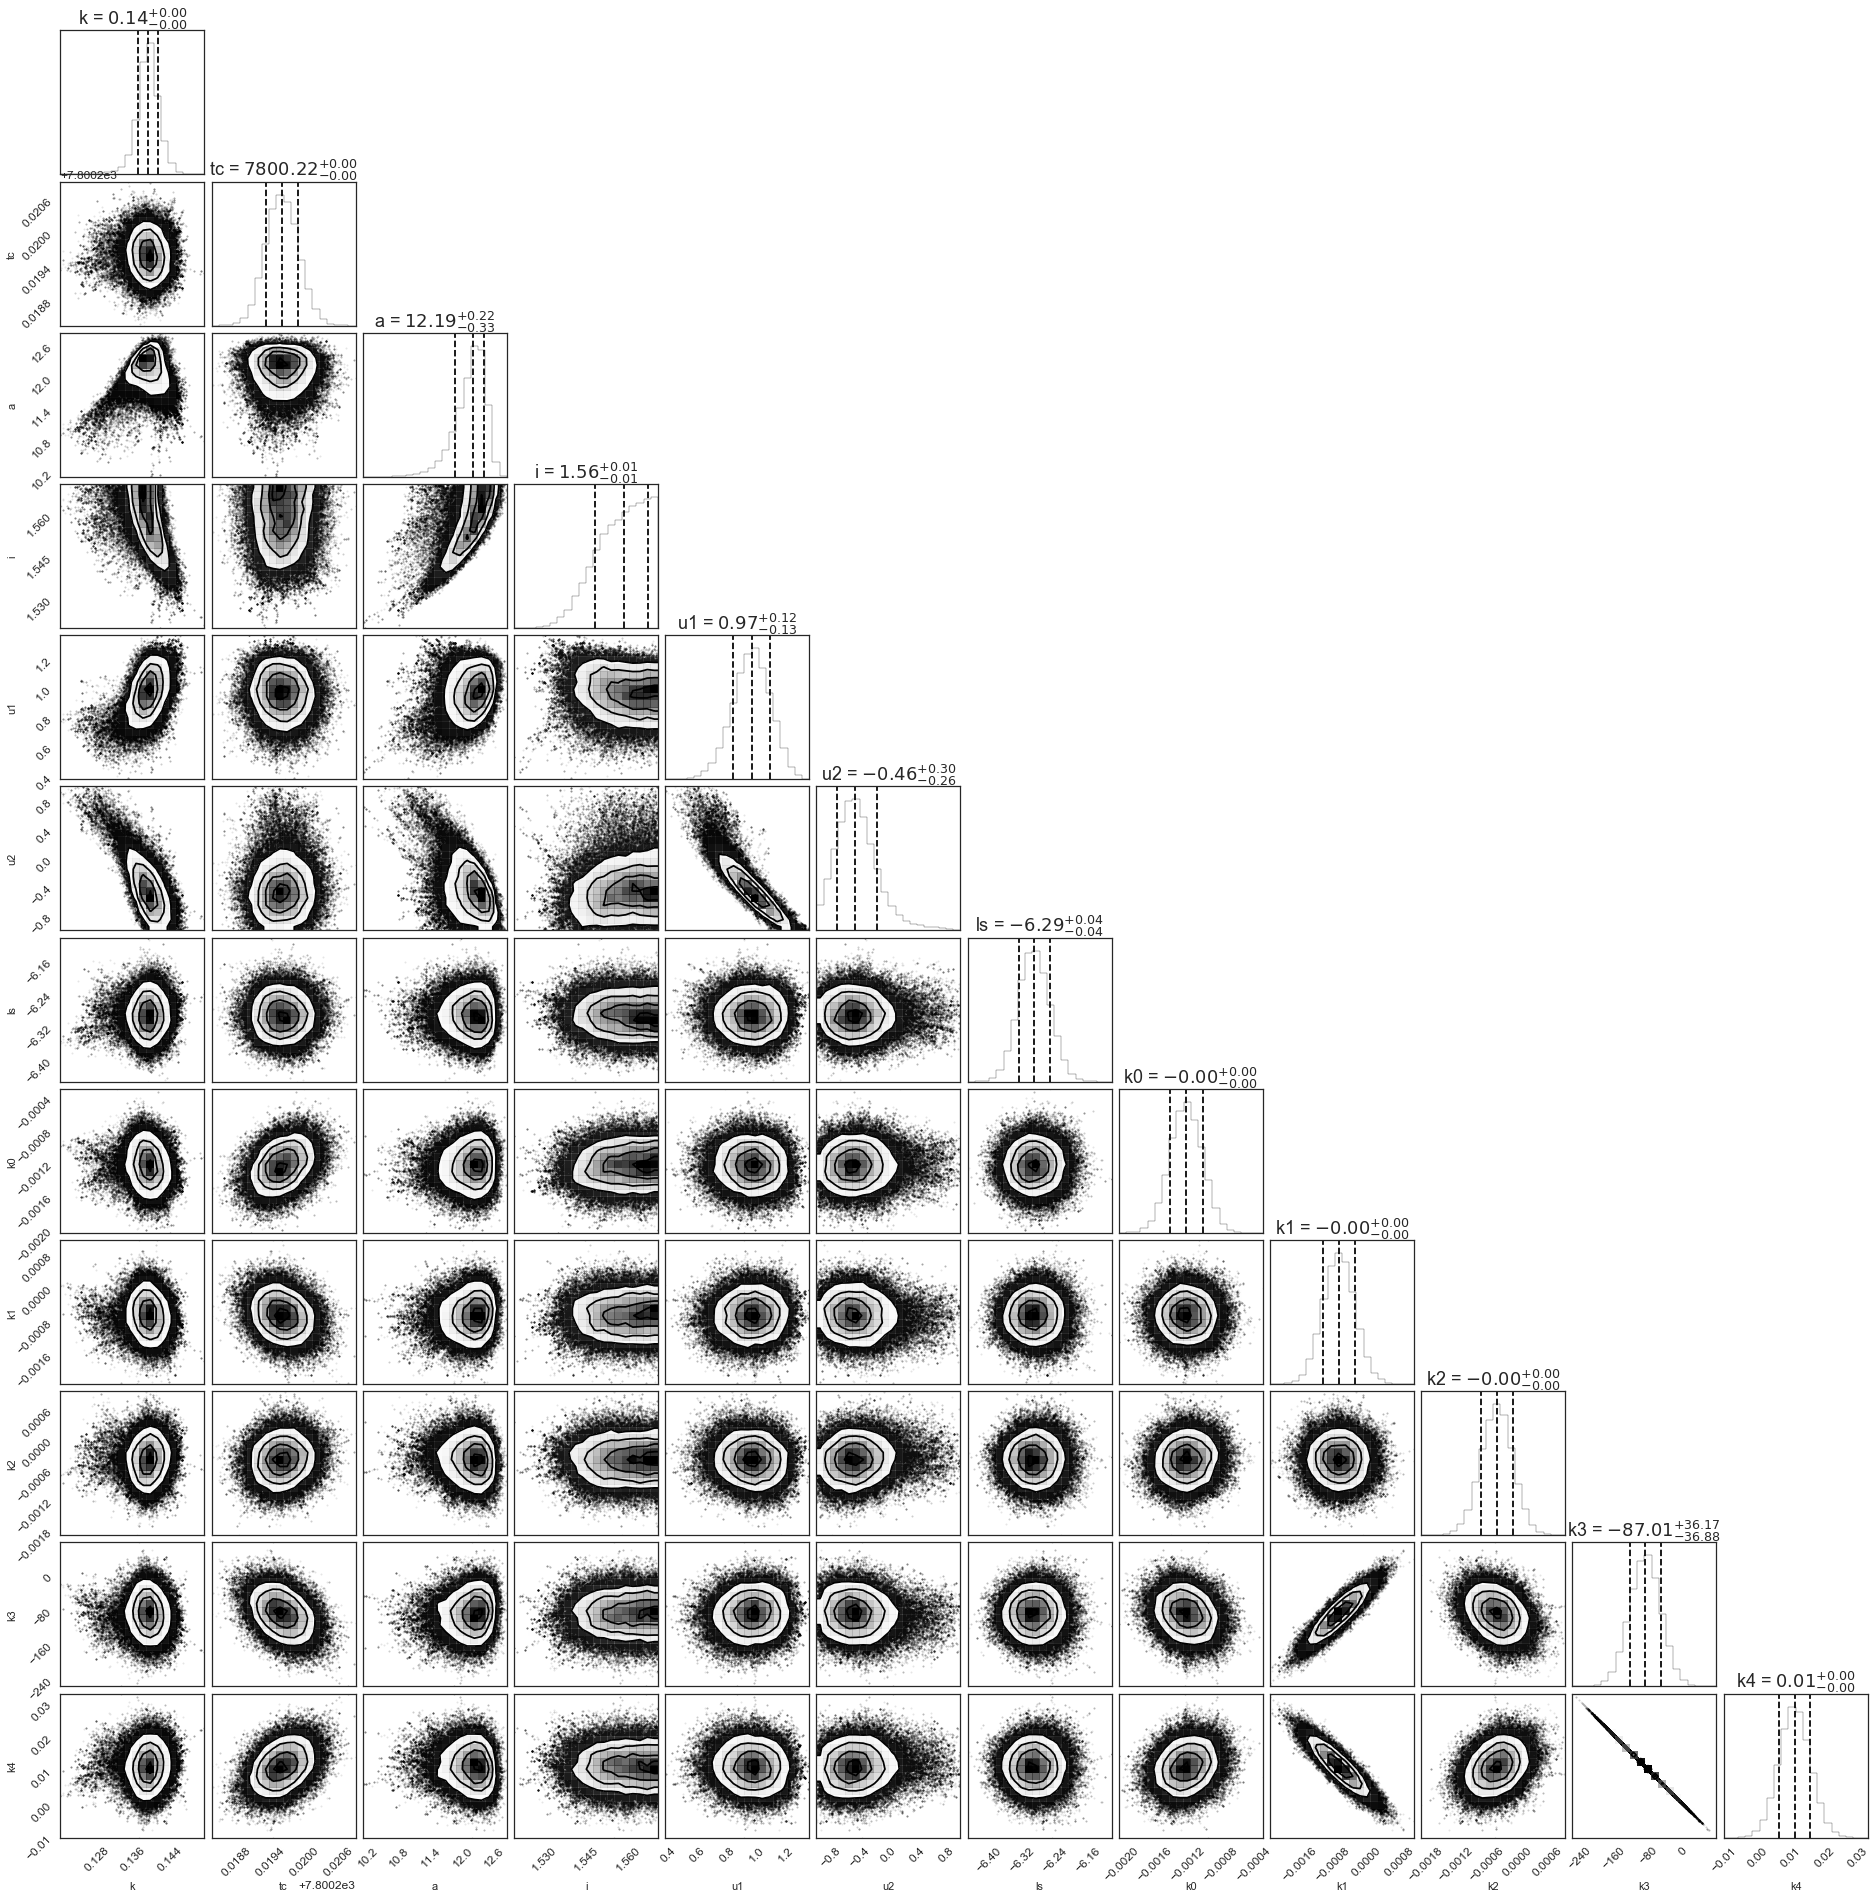

In [71]:
import corner

with sb.axes_style('white'):
    corner.corner(fc, labels=param_names, 
                  quantiles=[0.16, 0.5, 0.84], 
                  show_titles=True, title_kwargs={"fontsize": 18});

/home/jp/miniconda2/envs/moscatel/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  after removing the cwd from sys.path.


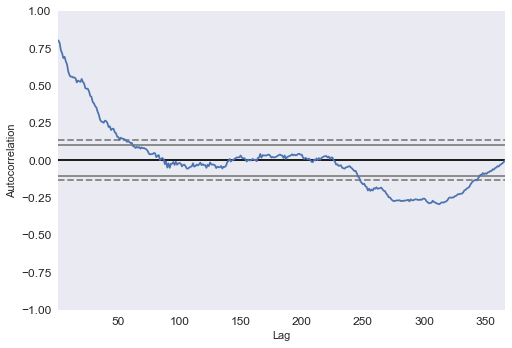

In [72]:
from pandas.tools.plotting import autocorrelation_plot

plt.figure()
autocorrelation_plot(MC_sys)

## Full model

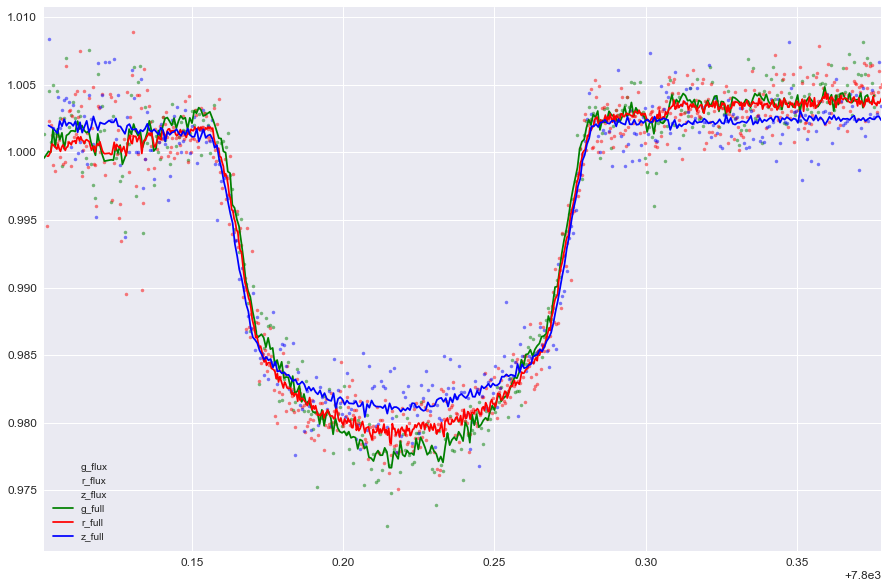

In [87]:
fig,ax=plt.subplots(1,1,figsize=(15,10))
cols='g_flux,r_flux,z_flux'.split(',')
#colors=['g','r','b']
final_df[cols].plot(marker='.', linestyle='', ax=ax,alpha=0.5,color=colors)
cols2='g_full,r_full,z_full'.split(',')
final_df[cols2].plot(ax=ax, color=colors)

## Corrected

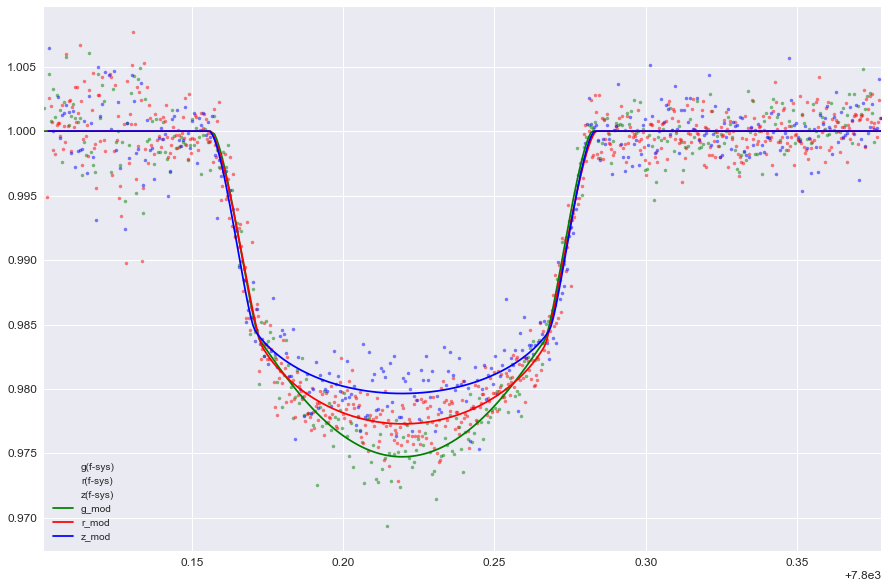

In [73]:
fig,ax=plt.subplots(1,1,figsize=(15,10))
cols='g(f-sys),r(f-sys),z(f-sys)'.split(',')
colors=['g','r','b']
final_df[cols].plot(marker='.',alpha=0.5, linestyle='', color=colors, ax=ax)
cols2='g_mod,r_mod,z_mod'.split(',')
final_df[cols2].plot(ax=ax, color=colors)

In [74]:
final_df.to_csv('final_grz.csv')

In [75]:
final_theta

{'g': array([  1.39091575e-01,   7.80021956e+03,   1.23091359e+01,
          1.55799997e+00,   1.04078154e+00,  -5.94422738e-01,
         -6.31099751e+00,  -1.22807142e-03,  -3.90144826e-04,
         -5.24408282e-04,  -5.97472826e+01,   7.66117066e-03]),
 'r': array([  1.38321620e-01,   7.80021988e+03,   1.16914674e+01,
          1.54271470e+00,   5.73623819e-01,  -2.73727253e-02,
         -6.31635644e+00,  -6.16960958e-04,   5.58016286e-05,
          1.88799233e-04,  -9.27104626e+01,   1.18864938e-02]),
 'z': array([  1.31476947e-01,   7.80021952e+03,   1.21833227e+01,
          1.56703318e+00,   4.37250724e-01,   4.09970581e-02,
         -6.22634595e+00,   3.14129000e-04,   8.03857163e-04,
          2.74405717e-04,  -7.48213700e+01,   9.59212234e-03])}

In [76]:
df_theta=pd.DataFrame(final_theta)
df_theta['names']=param_names
df_theta

g            r            z names
0      0.139092     0.138322     0.131477     k
1   7800.219561  7800.219878  7800.219518    tc
2     12.309136    11.691467    12.183323     a
3      1.558000     1.542715     1.567033     i
4      1.040782     0.573624     0.437251    u1
5     -0.594423    -0.027373     0.040997    u2
6     -6.310998    -6.316356    -6.226346    ls
7     -0.001228    -0.000617     0.000314    k0
8     -0.000390     0.000056     0.000804    k1
9     -0.000524     0.000189     0.000274    k2
10   -59.747283   -92.710463   -74.821370    k3
11     0.007661     0.011886     0.009592    k4

In [77]:
df_theta.to_csv('theta_post.csv')

(-0.10000000000000001,
 2.1000000000000001,
 0.0074499045014716474,
 0.012097759997744305)

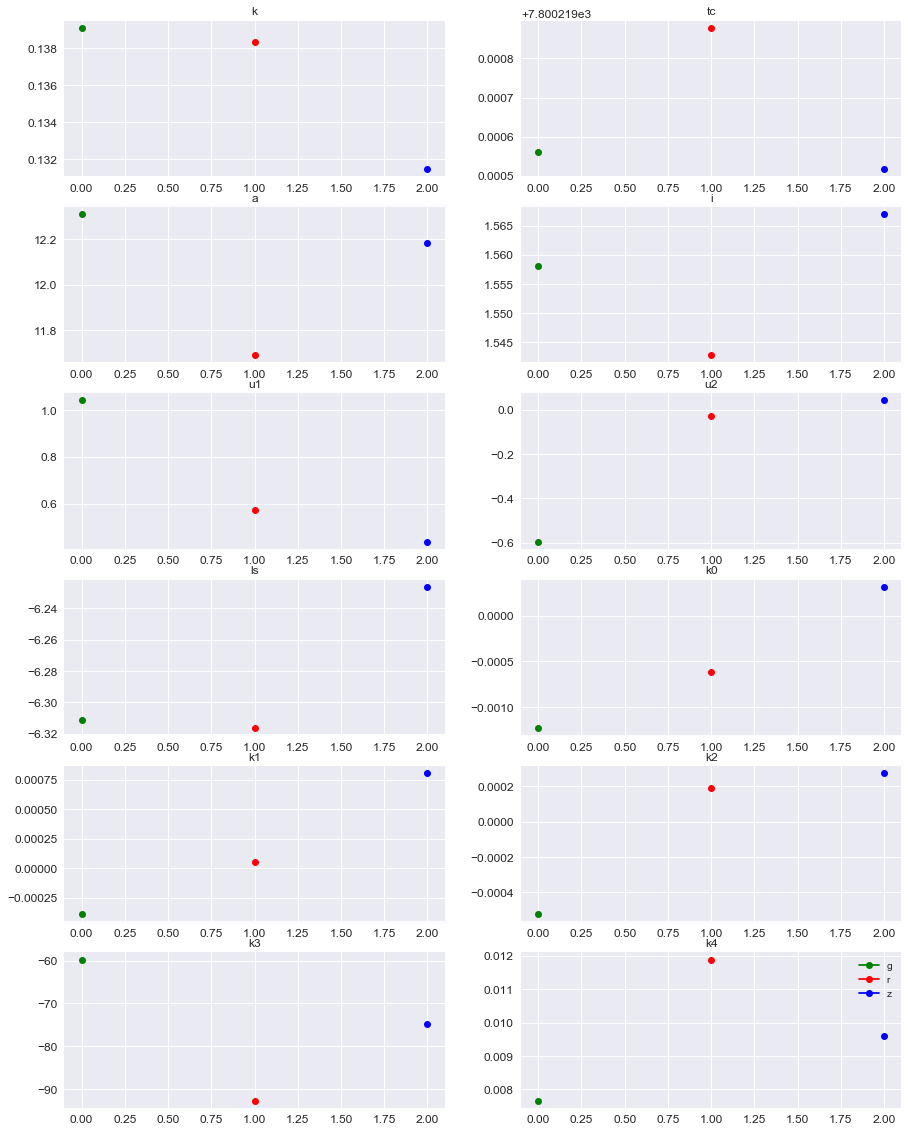

In [78]:
fig = plt.figure(figsize=(15,20))
#colors=
for idx,key in enumerate(sorted(final_theta)):
    for num, p in enumerate(range(len(final_theta[key]))):
        ax=plt.subplot(len(final_theta[key])/2,2,num+1)
        ax.plot(idx,final_theta[key][p], marker='o', color=colors[idx], label=key);
        ax.set_title(param_names[p])
plt.legend()
plt.axis('tight')

In [79]:
fname='hatp44b_grz.png'
plt.savefig(fname, bbox_inches='tight')

## Residuals

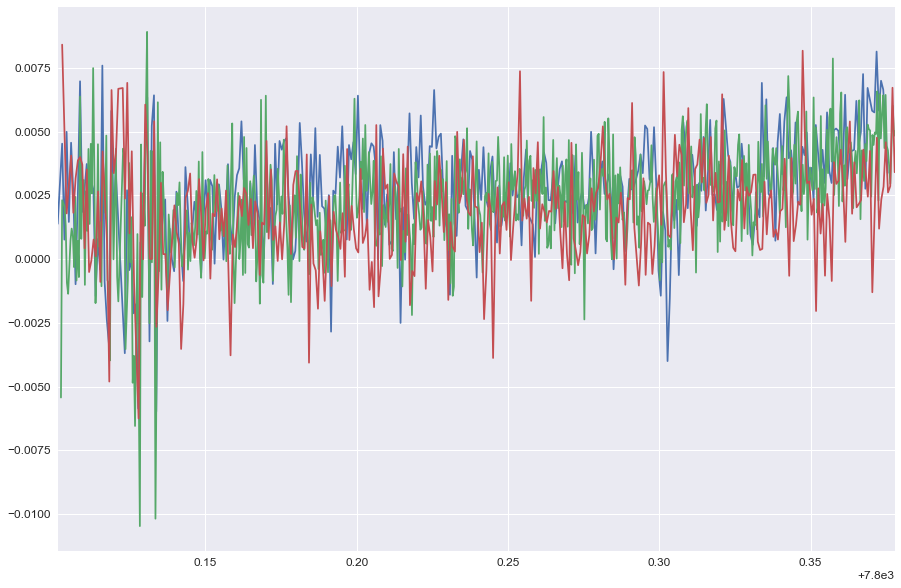

In [80]:
fig,ax=plt.subplots(1,1,figsize=(15,10))
diff1=final_df['g_flux'] - final_df['g_mod']
diff1.plot(ax=ax)
diff2=final_df['r_flux'] - final_df['r_mod']
diff2.plot(ax=ax)
diff3=final_df['z_flux'] - final_df['z_mod']
diff3.plot(ax=ax)

## Systematics

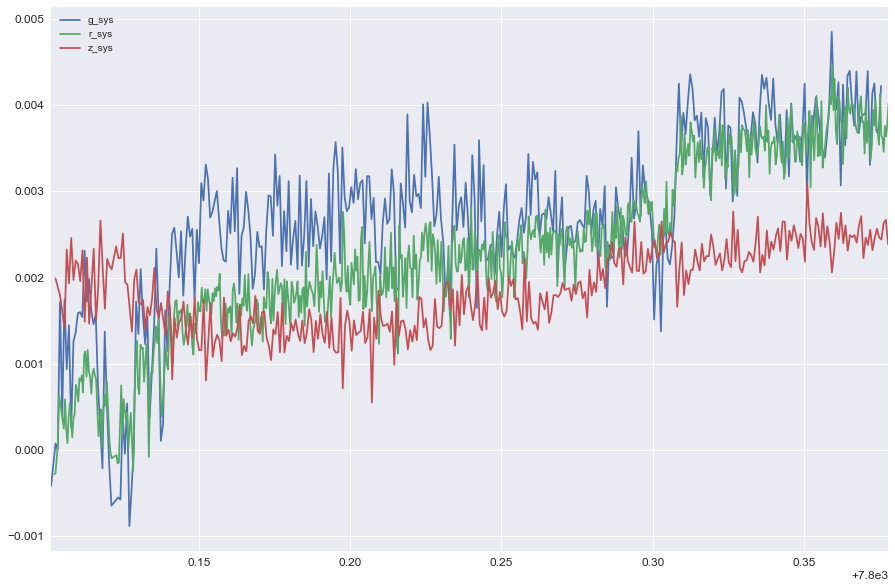

In [81]:
fig,ax=plt.subplots(1,1,figsize=(15,10))
cols3='g_sys,r_sys,z_sys'.split(',')
final_df[cols3].plot(ax=ax)

## To Do:

* use beta
* how to choose best light curves
* 